In [1]:
import pandas as pd
import numpy as np

reload_data = True
recalc_everything = True
save_figures = True

Mac_ = False
local_ = True

import altair as alt
print(alt.__version__)
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import altair_saver
import selenium
print(selenium.__version__)

from termcolor import colored

save_figures = True
import vl_convert as vlc
def save_chart(chart_to_save, filename):
    svg_str = vlc.vegalite_to_svg(chart_to_save.to_json())
    with open(filename, "wt") as f:
        f.write(svg_str)

import termcolor

import io
import os

from IPython.display import Markdown as md

%matplotlib inline
%config matplotlib_inline.matplotlib_formats = 'retina'
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

# chinese font
from matplotlib import font_manager
fontP = font_manager.FontProperties(fname="./NotoSerifTC-Regular.otf")
fontP.set_size(11)

import pathlib
import platform

import cmdstanpy as cmdstan
import arviz as az
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
standistribdir = '../../../../CmdStan'
cmdstan.set_cmdstan_path(standistribdir)


mainstandirname = '../../../Taiwan_Backup/Taiwan-Omicron_First100_2023'
os.makedirs(mainstandirname, exist_ok=True)
os.makedirs("results", exist_ok=True)

num_iterations = 12500
num_warmup = 2500
num_chains = 4

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5),
             "q25": lambda x: np.percentile(x, 25),
             "median": lambda x: np.percentile(x, 50),
             "q75": lambda x: np.percentile(x, 75),
             "q95": lambda x: np.percentile(x, 95),
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames, round_to_=5):
    # include mean and hdi
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75', 'q95', 'q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames, rounding=2):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95, round_to=rounding).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50, round_to=rounding).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False, round_to=rounding).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"] # via https://nanx.me/ggsci/index.html #blue = #74add1 #yellow = #fee391

# min reference date
mindate = pd.to_datetime('2021-12-20', format='%Y-%m-%d')
truncation_date = pd.to_datetime('2022-02-25', format='%Y-%m-%d')

datemin_plt = pd.to_datetime('2021-12-25', format='%Y-%m-%d')
datemax_plt = truncation_date
##########################

outputfile_parquet_inc = 'data_inc.parquet.gzip'
outputfile_parquet_SI = 'data_SI.parquet.gzip'

parquet_args = {
    'coerce_timestamps': 'us',
    'allow_truncated_timestamps': True,
}

import rpy2.rinterface
%load_ext rpy2.ipython
rpy2.robjects.r['options'](warn=-1)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='arviz')

import pyreadr

5.5.0
4.27.1


## <font color="darkred">I. Incubation period</font>

In [20]:
右截斷日_inc = pd.to_datetime("2022-01-18", format='%Y-%m-%d')

def get_df_inc():
    outputfile_inc = 'data_inc.pkl'
    if (reload_data)|(recalc_everything):
        datafile_inc = "../../data/paired_data_220826_v4_ara.xlsx"
        df_inc = pd.read_excel(datafile_inc, na_values=["NA","", " ", "疫調中","無症狀","調查中", "無"]).drop(['發病日_Andrei', 'Remarks', 'Remarks_2', 'Remarks_3'], axis=1)\
            .rename(columns = {'first_exposure_date': '首次曝光日', 'last_exposure_date': '末次曝光日', 'id': '案號', 'age': '年齡', 'gender': '性別'})
        print(df_inc.shape)
        df_inc = df_inc.drop(df_inc.columns[df_inc.columns.str.contains('Unnamed')], axis=1)
        df_inc['案號'] = [案號[1:] for 案號 in df_inc.案號]
        for col in df_inc.columns[df_inc.columns.str.contains("日")]:
            print(col)
            df_inc[col] = pd.to_datetime(df_inc[col], format="%Y-%m-%d")
        df_inc['case_id'] = df_inc.case_id.astype('str')
        df_inc['年齡'] = df_inc.年齡.astype('Int64')
        # we remove all cases with both unknown dates of exposure OR with both unknown date of symptom onset (=asymptomatic)
        df_inc = df_inc.loc[lambda d: ~(((pd.isnull(d.首次曝光日))&(pd.isnull(d.末次曝光日)))|(pd.isnull(d.發病日)))]
        # all onset dates were definitive in the dataset, so the lower boundary onset date was exactly the upper boundary date
        df_inc['首發病日'] = df_inc.發病日; df_inc['末發病日'] = df_inc.發病日  
        # if the upper boundary exposure date was not given, it was set to the upper boundary onset date
        df_inc['末次曝光日'] = [末發病日 if pd.isnull(末次曝光日) else 末次曝光日 for (末發病日, 末次曝光日) in zip(df_inc.末發病日, df_inc.末次曝光日)]
        # if the upper boundary exposure date was later than the upper boundary onset date, it was set to the upper boundary onset date
        df_inc['末次曝光日'] = [末發病日 if 末次曝光日 > 末發病日 else 末次曝光日 for (末發病日, 末次曝光日) in zip(df_inc.末發病日, df_inc.末次曝光日)]
        # transforming variables to number of days relatively to the mindate
        for col in df_inc.columns[df_inc.columns.str.contains("日")]:
            df_inc[col+"期"] = (df_inc[col] - df_inc['末次曝光日']).dt.days
        df_inc['右截斷日期'] = (右截斷日_inc - df_inc['末次曝光日']).dt.days
        df_inc = df_inc.loc[lambda d: ~((pd.isnull(d.首次曝光日))&(d.末次曝光日==d.末發病日))]
        print(df_inc.shape)
        df_inc.to_parquet(outputfile_parquet_inc, compression='gzip', **parquet_args)
    else:
        df_inc = pd.read_parquet(outputfile_parquet_inc)
    return df_inc

df_inc_raw = get_df_inc()
np.transpose(df_inc_raw.loc[lambda d: pd.isnull(d.首次曝光日)][-5:])

(114, 16)
首次曝光日
末次曝光日
發病日
通報日
研判日
確診日
PCR採檢日
(69, 28)


59                   66                   67   \
案號                          17735                17773                17774   
性別                              女                    女                    女   
年齡                             50                   55                   18   
vaccination                     是                    否                  NaN   
case_id                     17630                17717                17630   
首次曝光日                         NaT                  NaT                  NaT   
末次曝光日         2022-01-10 00:00:00  2022-01-10 00:00:00  2022-01-07 00:00:00   
contact_type            household            household               casual   
群聚\n編號         機場相關群聚-聯邦銀行-家庭群聚-1   機場相關群聚-聯邦銀行-家庭群聚-3   機場相關群聚-聯邦銀行-餐廳群聚-1   
發病日           2022-01-12 00:00:00  2022-01-13 00:00:00  2022-01-09 00:00:00   
通報日           2022-01-12 00:00:00  2022-01-13 00:00:00  2022-01-13 00:00:00   
研判日           2022-01-13 00:00:00  2022-01-13 00:00:00  2022-01-13 00:00:00   
確診日           2022-01-13 00:00:00  2022-01-14 00:00:00  2022-01-14 00:00:00   
PCR採檢日        2022-01-12 00:00:00  2022-01-13 00:00:00  2022-01-14 00:00:00   
Ct值_1                        29.2                 17.4                 22.5   
Ct值_2                         NaN                  NaN                  NaN   
首發病日          2022-01-12 00:00:00  2022-01-13 00:00:00  2022-01-09 00:00:00   
末發病日          2022-01-12 00:00:00  2022-01-13 00:00:00  2022-01-09 00:00:00   
首次曝光日期                        NaN                  NaN                  NaN   
末次曝光日期                          0                    0                    0   
發病日期                            2                    3                    2   
通報日期                          2.0                  3.0                  6.0   
研判日期                          3.0                  3.0                  6.0   
確診日期                          3.0                  4.0                  7.0   
PCR採檢日期                         2                    3                    7   
首發病日期                           2                    3                    2   
末發病日期                           2                    3                    2   
右截斷日期                           8                    8                   11   

                              110  
案號                          18055  
性別                              女  
年齡                             28  
vaccination                     是  
case_id                       nan  
首次曝光日                         NaT  
末次曝光日         2022-01-07 00:00:00  
contact_type          casual/work  
群聚\n編號                機場相關群聚-聯邦銀行  
發病日           2022-01-09 00:00:00  
通報日           2022-01-18 00:00:00  
研判日           2022-01-18 00:00:00  
確診日           2022-01-18 00:00:00  
PCR採檢日        2022-01-17 00:00:00  
Ct值_1                        18.9  
Ct值_2                         NaN  
首發病日          2022-01-09 00:00:00  
末發病日          2022-01-09 00:00:00  
首次曝光日期                        NaN  
末次曝光日期                          0  
發病日期                            2  
通報日期                         11.0  
研判日期                         11.0  
確診日期                         11.0  
PCR採檢日期                        10  
首發病日期                           2  
末發病日期                           2  
右截斷日期                          11

In [21]:
total_local = 100
print(total_local)

100


In [22]:
# vaccination
df_inc_raw['vaccination_status'] = [2 if vaccination=='是' else (1 if vaccination=='否' else 3) for vaccination in df_inc_raw.vaccination]
# age groups
bins = [0, 18, 50, 110]
labels = np.arange(1, len(bins))
df_inc_raw['age_group'] = pd.cut(df_inc_raw.年齡, bins = bins, labels = labels).astype('int')
# censoring
df_inc_raw['censored'] = [1 if (pd.isnull(首次曝光日))&(~pd.isnull(末次曝光日)) else 0 for 首次曝光日, 末次曝光日 in zip(df_inc_raw.首次曝光日, df_inc_raw.末次曝光日)]

In [23]:
# completely observed
df_inc_observed = df_inc_raw.loc[lambda d: (~pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))]
N_inc_observed = len(df_inc_observed)
# right censored
df_inc_censored = df_inc_raw.loc[lambda d: (pd.isnull(d.首次曝光日))&(~pd.isnull(d.末次曝光日))]
N_inc_censored = len(df_inc_censored)

# total number of analyzed cases 
N_inc = N_inc_observed + N_inc_censored
df_inc = pd.concat([df_inc_observed, df_inc_censored], ignore_index=True)

In [24]:
md(f"In this part we analyzed the first {total_local} local infections of Omicron variant which were reported in Taiwan in 27 December 2021 – 18 January 2022. In each case we attempted to determine the exposure and symptom onset time intervals. In the best situation, the interval can be identified with precision to one day. However, some records did not contained either the exposure interval or the symptom onset interval completely. These records were omitted from the analysis. Otherwise, the time interval was identified at least partially, either with known lower or with known upper boundary of the time interval.\n \n Additionally, we performed the following assignments: \n * when the upper boundary of the exposure interval was unidentified, it was set to the upper boundary of the symptom onset interval \n * when the upper boudary of the exposure interval was later that the upper boundary of the symptom onset interval, it was set to the latter \n * all onset dates were definitive in the dataset, so the respective interval was a one-day long \n * the requirement that the symptom onset cannot happen earlier than the exposure to the virus was also incurred. \n \n In total **{len(df_inc)} records** were aggregated, which included:\n * **{N_inc_observed} records** with completely observed exposure interval \n * **{N_inc_censored} records** with right censored exposure interval")

In this part we analyzed the first 100 local infections of Omicron variant which were reported in Taiwan in 27 December 2021 – 18 January 2022. In each case we attempted to determine the exposure and symptom onset time intervals. In the best situation, the interval can be identified with precision to one day. However, some records did not contained either the exposure interval or the symptom onset interval completely. These records were omitted from the analysis. Otherwise, the time interval was identified at least partially, either with known lower or with known upper boundary of the time interval.
 
 Additionally, we performed the following assignments: 
 * when the upper boundary of the exposure interval was unidentified, it was set to the upper boundary of the symptom onset interval 
 * when the upper boudary of the exposure interval was later that the upper boundary of the symptom onset interval, it was set to the latter 
 * all onset dates were definitive in the dataset, so the respective interval was a one-day long 
 * the requirement that the symptom onset cannot happen earlier than the exposure to the virus was also incurred. 
 
 In total **69 records** were aggregated, which included:
 * **65 records** with completely observed exposure interval 
 * **4 records** with right censored exposure interval

In [25]:
# one-day exposure window
np.transpose(df_inc_observed.loc[lambda d: d.首次曝光日期-d.末次曝光日期==-1])

47                   54  \
案號                                17672                17721   
性別                                    男                    女   
年齡                                   25                   28   
vaccination                         NaN                    是   
case_id                           17630                17630   
首次曝光日               2022-01-06 00:00:00  2022-01-06 00:00:00   
末次曝光日               2022-01-07 00:00:00  2022-01-07 00:00:00   
contact_type                work/casual          work/casual   
群聚\n編號                      機場相關群聚-聯邦銀行          機場相關群聚-聯邦銀行   
發病日                 2022-01-10 00:00:00  2022-01-09 00:00:00   
通報日                 2022-01-12 00:00:00  2022-01-12 00:00:00   
研判日                 2022-01-12 00:00:00  2022-01-12 00:00:00   
確診日                 2022-01-12 00:00:00  2022-01-13 00:00:00   
PCR採檢日              2022-01-12 00:00:00  2022-01-12 00:00:00   
Ct值_1                              16.8                 19.3   
Ct值_2                               NaN                  NaN   
首發病日                2022-01-10 00:00:00  2022-01-09 00:00:00   
末發病日                2022-01-10 00:00:00  2022-01-09 00:00:00   
首次曝光日期                             -1.0                 -1.0   
末次曝光日期                                0                    0   
發病日期                                  3                    2   
通報日期                                5.0                  5.0   
研判日期                                5.0                  5.0   
確診日期                                5.0                  6.0   
PCR採檢日期                               5                    5   
首發病日期                                 3                    2   
末發病日期                                 3                    2   
右截斷日期                                11                   11   
vaccination_status                    3                    2   
age_group                             2                    2   
censored                              0                    0   

                                     56                       94  
案號                                17723                    17972  
性別                                    女                        女  
年齡                                   31                       36  
vaccination                           是                        否  
case_id                           17630                    17883  
首次曝光日               2022-01-06 00:00:00      2022-01-10 00:00:00  
末次曝光日               2022-01-07 00:00:00      2022-01-11 00:00:00  
contact_type                work/casual                     work  
群聚\n編號                      機場相關群聚-聯邦銀行  機場相關群聚-聯邦銀行-餐廳-仁寶電子群聚-1  
發病日                 2022-01-10 00:00:00      2022-01-14 00:00:00  
通報日                 2022-01-12 00:00:00      2022-01-16 00:00:00  
研判日                 2022-01-12 00:00:00      2022-01-16 00:00:00  
確診日                 2022-01-13 00:00:00      2022-01-17 00:00:00  
PCR採檢日              2022-01-12 00:00:00      2022-01-16 00:00:00  
Ct值_1                              23.3                     21.2  
Ct值_2                               NaN                      NaN  
首發病日                2022-01-10 00:00:00      2022-01-14 00:00:00  
末發病日                2022-01-10 00:00:00      2022-01-14 00:00:00  
首次曝光日期                             -1.0                     -1.0  
末次曝光日期                                0                        0  
發病日期                                  3                        3  
通報日期                                5.0                      5.0  
研判日期                                5.0                      5.0  
確診日期                                6.0                      6.0  
PCR採檢日期                               5                        5  
首發病日期                                 3                        3  
末發病日期                                 3                        3  
右截斷日期                                11                        7  
vaccination_status                    2      

In [26]:
len(df_inc_raw.age_group.drop_duplicates())

3

In [27]:
# male cases
df_inc.loc[lambda d: d.性別=='男'].shape[0]

26

In [28]:
print('Total number of analyzed cases:', df_inc.shape[0])
females_number = df_inc.loc[lambda d: d.性別=='女'].shape[0]
print(f'Mean age: {df_inc.年齡.mean():.1f}; range {df_inc.年齡.min():.0f}-{df_inc.年齡.max():.0f}. Number of females: {females_number:.0f} ({females_number / df_inc.shape[0] * 100:.1f}%)')

Total number of analyzed cases: 69
Mean age: 35.4; range 1-66. Number of females: 43 (62.3%)


In [29]:
df_inc_unknown_status_vaccinated = df_inc.loc[lambda d: pd.isnull(d.vaccination)]
print(f'Number of cases with unknown status of vaccination: {df_inc_unknown_status_vaccinated.shape[0]} ({100.*df_inc_unknown_status_vaccinated.shape[0] / df_inc.shape[0]:.1f}%)')

Number of cases with unknown status of vaccination: 13 (18.8%)


In [30]:
df_inc_nonvaccinated = df_inc.loc[lambda d: d.vaccination == '否']
print(f'Number of non-vaccinated people: {df_inc_nonvaccinated.shape[0]} ({100.*df_inc_nonvaccinated.shape[0]/df_inc.shape[0]:.1f}%)')

print(f'Mean age: {df_inc_nonvaccinated.年齡.mean():.1f}; range {df_inc_nonvaccinated.年齡.min():.0f}-{df_inc_nonvaccinated.年齡.max():.0f}')

Number of non-vaccinated people: 16 (23.2%)
Mean age: 22.6; range 1-57


In [31]:
df_inc_vaccinated = df_inc.loc[lambda d: d.vaccination=='是']
print(f'Number of vaccinated people: {df_inc_vaccinated.shape[0]} ({100.*df_inc_vaccinated.shape[0]/df_inc.shape[0]:.1f}%)')

print(f'Mean age: {df_inc_vaccinated.年齡.mean():.1f}; range {df_inc_vaccinated.年齡.min():.0f}-{df_inc_vaccinated.年齡.max():.0f}')

Number of vaccinated people: 40 (58.0%)
Mean age: 40.3; range 17-66


In [32]:
def runSimulation_time_interval_Taiwan(df_inc = df_inc_raw, distrib = 'GGD'):
    basename = f'{右截斷日_inc.strftime("%Y%m%d")}_incubation_period_{distrib}-Taiwan'
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    
    stan_code_file = os.path.join(standirname, f'{basename}.stan')
    if distrib=='GGD':
        !cat stan_src/incper-{distrib}_with_subgroups.stan > {stan_code_file}
    else:
        !cat stan_src/incper-{distrib}.stan > {stan_code_file}

    df_inc_ = df_inc.copy()
    df_inc_.loc[lambda d: d.censored == 1, '首次曝光日期'] = -100.0

    M_ = 180
    inc_per_max_ = 12

    stan_data = dict({
        'N': df_inc_.shape[0],
        'exposureL': df_inc_.首次曝光日期.values, 
        'exposureR': df_inc_.末次曝光日期.values + 1, 
        'onsetL': df_inc_.首發病日期.values,  
        'onsetR': df_inc_.末發病日期.values + 1, 
        'truncation_day': df_inc_.右截斷日期.values,
        'censored': np.array(df_inc_.censored.values, dtype='int'),
        'vaccination_status_record': df_inc_.vaccination_status.values,
        'age_group_record': df_inc_.age_group.values,
        'A': len(df_inc_raw.age_group.drop_duplicates()),
        'V': len(df_inc_raw.vaccination_status.drop_duplicates()),
        'M': M_,
        'incper_max': inc_per_max_,
        'mean_prior': 0.0,
        'sd_prior': 2.0
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)
        
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit = model.sample(data = stan_data_file, seed = 20, iter_warmup = num_warmup, iter_sampling = num_iterations,##,
                       show_console = False, show_progress = True, chains = num_chains, adapt_delta = 0.999) 
    fit.save_csvfiles(dir=standirname)

    return fit

for distrib_ in ['GGD', 'lognormal', 'Weibull', 'gamma', 'mixture']:
    globals()[f'fit_{distrib_}'] = runSimulation_time_interval_Taiwan(distrib = distrib_)

11:08:12 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_GGD-Taiwan/20220118_incubation_period_GGD-Taiwan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_GGD-Taiwan/20220118_incubation_period_GGD-Taiwan
11:08:22 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_GGD-Taiwan/20220118_incubation_period_GGD-Taiwan
11:08:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:10:01 - cmdstanpy - INFO - CmdStan done processing.
11:10:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '20220118_incubation_period_GGD-Taiwan.stan', line 23, column 4 to column 80) (in '20220118_incubation_period_GGD-Taiwan.stan', line 135, column 4 to line 136, column 74)
	Exception: Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '20220118_incubation_period_GGD-Taiwan.stan', line 23, column 4 to column 80) (in '20220118_incubation_period_GGD-Taiwan.stan', line 135, column 4 to line 136, column 74)
	Exception: Exception: gamma_lpdf: Random variable[1] is 0, but must be positive finite! (in '20220118_incubation_period_GGD-Taiwan.stan', line 23, column 4 to column 80) (in '20220118_incubation_period_GGD-Taiwan.stan', line 135, column 4 to line 136, column 74)
Exception: Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite

11:10:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
11:10:03 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_lognormal-Taiwan/20220118_incubation_period_lognormal-Taiwan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_lognormal-Taiwan/20220118_incubation_period_lognormal-Taiwan
11:10:11 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_lognormal-Taiwan/20220118_incubation_period_lognormal-Taiwan
11:10:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:10:39 - cmdstanpy - INFO - CmdStan done processing.
11:10:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '20220118_incubation_period_lognormal-Taiwan.stan', line 67, column 4 to line 68, column 81)
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '20220118_incubation_period_lognormal-Taiwan.stan', line 67, column 4 to line 68, column 81)
Exception: lognormal_lpdf: Location parameter is -inf, but must be finite! (in '20220118_incubation_period_lognormal-Taiwan.stan', line 67, column 4 to line 68, column 81)
	Exception: lognormal_lpdf: Location parameter is -inf, but must be finite! (in '20220118_incubation_period_lognormal-Taiwan.stan', line 67, column 4 to line 68, column 81)
	Exception: lognormal_lpdf: Location parameter is -inf, but must be finite! (in '20220118_incubation_period_lognormal-Taiwan.stan', line 67, column 4 to line 68, column 81)
Consider re-run

11:10:40 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_Weibull-Taiwan/20220118_incubation_period_Weibull-Taiwan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_Weibull-Taiwan/20220118_incubation_period_Weibull-Taiwan
11:10:48 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_Weibull-Taiwan/20220118_incubation_period_Weibull-Taiwan
11:10:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:11:20 - cmdstanpy - INFO - CmdStan done processing.
11:11:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: _20220118_incubation_period_Weibull_Taiwan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20220118_incubation_period_Weibull-Taiwan.stan', line 32, column 4 to line 35, column 101)
	Exception: _20220118_incubation_period_Weibull_Taiwan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20220118_incubation_period_Weibull-Taiwan.stan', line 32, column 4 to line 35, column 101)
	Exception: _20220118_incubation_period_Weibull_Taiwan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20220118_incubation_period_Weibull-Taiwan.stan', line 32, column 4 to line 35, column 101)
	Exception: _20220118_incubation_period_Weibull_Taiwan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 

11:11:21 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_gamma-Taiwan/20220118_incubation_period_gamma-Taiwan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_gamma-Taiwan/20220118_incubation_period_gamma-Taiwan
11:11:28 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_gamma-Taiwan/20220118_incubation_period_gamma-Taiwan
11:11:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:14:03 - cmdstanpy - INFO - CmdStan done processing.
11:14:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter is inf, but must be positive finite! (in '20220118_incubation_period_gamma-Taiwan.stan', line 67, column 4 to line 68, column 77)
Exception: gamma_lpdf: Shape parameter is inf, but must be positive finite! (in '20220118_incubation_period_gamma-Taiwan.stan', line 67, column 4 to line 68, column 77)
Exception: gamma_lpdf: Shape parameter is 0, but must be positive finite! (in '20220118_incubation_period_gamma-Taiwan.stan', line 67, column 4 to line 68, column 77)
	Exception: gamma_lpdf: Shape parameter is 0, but must be positive finite! (in '20220118_incubation_period_gamma-Taiwan.stan', line 67, column 4 to line 68, column 77)
	Exception: gamma_lpdf: Shape parameter is 0, but must be positive finite! (in '20220118_incubation_period_gamma-Taiwan.stan', line 67, column 4 to line 68, column 77)
	Exception: gamma_lpdf: Random variabl

11:14:04 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_mixture-Taiwan/20220118_incubation_period_mixture-Taiwan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_mixture-Taiwan/20220118_incubation_period_mixture-Taiwan
11:14:15 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20220118_incubation_period_mixture-Taiwan/20220118_incubation_period_mixture-Taiwan
11:14:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:16:50 - cmdstanpy - INFO - CmdStan done processing.
11:16:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '20220118_incubation_period_mixture-Taiwan.stan', line 81, column 8 to column 134)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '20220118_incubation_period_mixture-Taiwan.stan', line 81, column 8 to column 134)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '20220118_incubation_period_mixture-Taiwan.stan', line 81, column 8 to column 134)
	Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '20220118_incubation_period_mixture-Taiwan.stan', line 81, column 8 to column 134)
Exception: gamma_lpdf: Shape parameter is nan, but must be positive finite! (in '20220118_incubation_period_mixture-Taiwan.stan', line 81, column 8 to column 134)
	Exception: gamma_lpdf: Shape parameter is nan, but must be p

In [33]:
# GGD
distrib_ = 'GGD'
print(colored(distrib_, "red"))
idata_ = az.from_cmdstanpy(posterior=globals()[f'fit_{distrib_}'],
        posterior_predictive=["pred_interval"], dtypes={"pred_interval": float})
df_fit_Taiwan = pd.concat([get_stats(idata_.posterior, ['mean_interval', 'sd_interval', 'mu', 'sigma', 'q']),
            get_stats(idata_.posterior_predictive, ['pred_interval'])],ignore_index=True).rename(columns = {'time': 'idx', 'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
df_fit_Taiwan['distribution'] = distrib_
display(np.round(df_fit_Taiwan, 3))

df_draws_Taiwan = pd.DataFrame(idata_.posterior_predictive['pred_interval'].values.flatten(), columns = ['interval'])
df_draws_Taiwan['distribution'] = distrib_

GGD


var idx   mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  IQR_lower  \
0  mean_interval  NA  3.501   3.033  3.334  3.656    3.974  3.034      3.338   
1    sd_interval  NA  1.268   0.918  1.095  1.335    1.644  0.949      1.135   
2             mu  NA  1.341   1.166  1.274  1.392    1.519  1.169      1.281   
3          sigma  NA  0.338   0.228  0.290  0.367    0.464  0.233      0.296   
4              q  NA  0.887   0.307  0.573  0.968    1.549  0.384      0.646   
5  pred_interval  NA  3.504   1.004  2.432  4.195    6.007  1.144      2.578   

   median  IQR_upper    q95  upper   ess_bulk   ess_tail  r_hat distribution  
0   3.499      3.661  3.899  3.975  24810.898  31760.680    1.0          GGD  
1   1.249      1.380  1.604  1.694  15303.029  27787.159    1.0          GGD  
2   1.339      1.399  1.490  1.524  25095.174  28885.610    1.0          GGD  
3   0.333      0.375  0.446  0.472  15320.070  26752.394    1.0          GGD  
4   0.830      1.063  1.514  1.719  29926.993  26929.362    1.0          GGD  
5   3.450      4.351  5.712  6.201  50260.250  47879.041    1.0          GGD

In [34]:
distrib_ = 'GGD'
idata = az.from_cmdstanpy(posterior=globals()[f'fit_{distrib_}'])
df_inc_mean_SD = az.extract_dataset(idata)
ylbs = ['Mean incubation period (days)', 'SD of incubation period (days)']
df_inc_mean_SD = pd.DataFrame({ylbs[0]: df_inc_mean_SD.mean_interval.values, ylbs[1]: df_inc_mean_SD.sd_interval.values}).reset_index()

chart = alt.Chart(df_inc_mean_SD).mark_line(size=.1).encode(
    alt.X('index', title='Iteration'), 
    alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type='quantitative')
    ).properties(width=250, height=180
    ).repeat(
        column = ylbs
    ).configure_axis(grid=False)

figuresdir = '../../figures_ms/draft'
if save_figures:
    save_chart(chart, f'{figuresdir}/Fig_inc_per_{distrib_}_iterations.svg')

chart

alt.RepeatChart(...)

In [35]:
mu_incper_current_study = df_inc_mean_SD['Mean incubation period (days)'].values
mean_current_study = np.mean(mu_incper_current_study)
mean_lower_current_study, mean_IQR_lower_current_study, mean_IQR_upper_current_study, mean_upper_current_study = np.percentile(mu_incper_current_study, [2.5, 25, 75, 97.5])
print(mean_current_study, mean_lower_current_study, mean_IQR_lower_current_study, mean_IQR_upper_current_study, mean_upper_current_study)

3.5005339677999996 3.033722 3.33815 3.66091 3.97539275


In [36]:
df_current_study = pd.DataFrame({'mu': [mean_current_study], 
                                 'mu_lower': [mean_lower_current_study], 
                                 'mu_IQR_lower': [mean_IQR_lower_current_study], 
                                 'mu_IQR_upper': [mean_IQR_upper_current_study], 
                                 'mu_upper': [mean_upper_current_study]})
df_current_study['Source'] = 'Present study'
df_current_study['Cases'] = N_inc
df_current_study

mu  mu_lower  mu_IQR_lower  mu_IQR_upper  mu_upper         Source  \
0  3.500534  3.033722       3.33815       3.66091  3.975393  Present study   

   Cases  
0     69

In [37]:
summary_subgroups = get_stats(idata_.posterior, ['mean_interval_vac', 'mean_interval_age']).rename(columns = {'time': 'subgroup_idx'})
summary_subgroups

var  subgroup_idx     mean   hdi2.5    hdi25    hdi75  \
0  mean_interval_vac             1  3.78690  3.25386  3.59671  3.96589   
1  mean_interval_vac             2  3.38315  2.97917  3.24607  3.52905   
2  mean_interval_vac             3  3.33938  2.71070  3.11228  3.54892   
3  mean_interval_age             1  3.51862  2.80431  3.25553  3.73146   
4  mean_interval_age             2  3.36543  2.98820  3.23604  3.49764   
5  mean_interval_age             3  3.73755  3.09281  3.50281  3.93886   

   hdi97.5     q2.5      q25   median      q75      q95    q97.5     ess_bulk  \
0  4.32493  3.26248  3.60002  3.78272  3.96966  4.24530  4.33462  37324.03967   
1  3.79420  2.97054  3.24169  3.38335  3.52532  3.72430  3.78665  22991.96251   
2  3.98179  2.69776  3.12050  3.34039  3.55771  3.86937  3.97073  33068.41333   
3  4.20618  2.82539  3.27842  3.51648  3.75618  4.10849  4.23057  35397.46438   
4  3.74125  2.98558  3.23609  3.36573  3.49770  3.67990  3.73944  22607.48370   
5  4.38056  3.10749  3.51602  3.73174  3.95364  4.28520  4.39834  35845.22900   

      ess_tail    r_hat  
0  35645.80400  1.00009  
1  30927.66039  0.99999  
2  38741.11283  1.00005  
3  35145.55718  1.00014  
4  31620.72596  1.00006  
5  37540.96999  0.99999

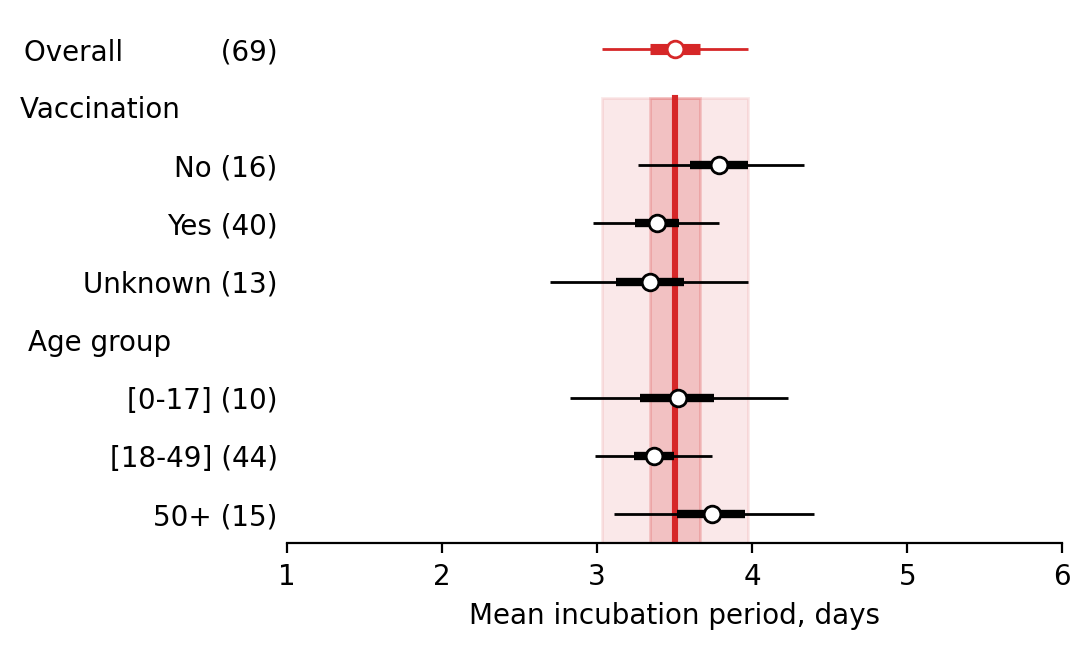

In [38]:
fig = plt.figure(figsize = [5, 3.4])
ax = fig.add_subplot()
xmx = 6
cpsz = 0

# overall
df_curr = df_current_study.copy()
df_curr['Source'] = f"Overall           ({df_curr['Cases'].values[0]})"

ax.errorbar(x=list(df_curr['mu']), y = 1.0,
            xerr=[list(df_curr['mu'] - df_curr['mu_lower']), list(df_curr['mu_upper'] - df_curr['mu'])], 
            color='C3', capsize=cpsz,
            linestyle='None', linewidth=1, markersize=0)
ax.errorbar(x=list(df_curr['mu']), y = 1.0,
            xerr=[list(df_curr['mu'] - df_curr['mu_IQR_lower']), list(df_curr['mu_IQR_upper'] - df_curr['mu'])], 
            color='C3', capsize=cpsz,
            linestyle='None', linewidth=4, markersize=0)
ax.plot(list(df_curr['mu']), 1.0, color='C3', mfc='w', linestyle='None', linewidth=1, marker="o", ms=6)

ymx_ = .85
ax.axvline(x = df_curr['mu'].values[0], ymax = ymx_, linestyle='solid', lw = 2.2, color='C3', zorder=-20)
ax.axvspan(xmin = df_curr['mu_lower'].values[0], 
           xmax = df_curr['mu_upper'].values[0],
           ymax = ymx_,
           alpha = .1, zorder = -21, color='C3')
ax.axvspan(xmin = df_curr['mu_IQR_lower'].values[0], 
           xmax = df_curr['mu_IQR_upper'].values[0], 
           ymax = ymx_,
           alpha = .2, zorder = -21, color='C3')

# by vaccination
df_ = summary_subgroups.loc[lambda d: d['var']=='mean_interval_vac'].copy()
cases_ = df_inc_raw.groupby('vaccination_status')['vaccination_status'].count().values
df_['Source'] = [f'No ({cases_[0]})', f'Yes ({cases_[1]})', f'Unknown ({cases_[2]})']
df_['Source_y'] = [.5 - (i + 1) * .5 for i in range(df_.shape[0])]

ax.errorbar(x=list(df_['mean']), y=df_['Source_y'], 
            xerr=[list(df_['mean'] - df_['q2.5']), list(df_['q97.5'] - df_['mean'])], 
            color='k', capsize=cpsz,
            linestyle='None', linewidth=1, markersize=0)
ax.errorbar(x=list(df_['mean']), y=df_['Source_y'], 
            xerr=[list(df_['mean'] - df_['q25']), list(df_['q75'] - df_['mean'])], 
            color='k', capsize=cpsz,
            linestyle='None', linewidth=3, markersize=0)
ax.plot(list(df_['mean']), df_['Source_y'], color='k', mfc='w', 
        linestyle='None', linewidth=1, marker="o", ms=6)

y__ = np.min(df_['Source_y'])

# by age group
df__ = summary_subgroups.loc[lambda d: d['var']=='mean_interval_age'].copy()
cases_ = df_inc_raw.groupby('age_group')['age_group'].count().values
df__['Source'] = [f'[0-17] ({cases_[0]})', f'[18-49] ({cases_[1]})', f'50+ ({cases_[2]})']
df__['Source_y'] = [y__ - .5 - (i + 1) * .5 for i in range(df__.shape[0])]

ax.errorbar(x=list(df__['mean']), y=df__['Source_y'], 
            xerr=[list(df__['mean'] - df__['q2.5']), list(df__['q97.5'] - df__['mean'])], 
            color='k', capsize=cpsz,
            linestyle='None', linewidth=1, markersize=0)
ax.errorbar(x=list(df__['mean']), y=df__['Source_y'], 
            xerr=[list(df__['mean'] - df__['q25']), list(df__['q75'] - df__['mean'])], 
            color='k', capsize=cpsz,
            linestyle='None', linewidth=3, markersize=0)
ax.plot(list(df__['mean']), df__['Source_y'], color='k', mfc='w', 
        linestyle='None', linewidth=1, marker="o", ms=6)

# plt.text(.98, 1.02, 'Subgroup   (Cases)', horizontalalignment='right', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left = 1, right = 6)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlabel("Mean incubation period, days")
ax.set_yticks(np.r_[[1.0, 0.5], df_['Source_y'], [y__ - 0.5], df__['Source_y']])
ax.set_yticklabels(np.r_[df_curr['Source'], ['Vaccination           '], df_['Source'], ['Age group            '], df__['Source']])
ax.set_ylim(np.min(df__['Source_y']) - .25, 1.25)
ax.tick_params(axis='y', length=0)

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-inc_subgroup.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [39]:
# mixture model
distrib_ = 'mixture'
print(colored(distrib_, "red"))
idata_ = az.from_cmdstanpy(posterior=globals()[f'fit_{distrib_}'],
        posterior_predictive = ["pred_interval", "q", "comp"], 
        dtypes = {"pred_interval": float, "q": float, "comp": int})
df_fit_ = pd.concat([get_stats(idata_.posterior, ['mean_interval', 'sd_interval']),
            get_stats(idata_.posterior_predictive, ['pred_interval'])],ignore_index=True).rename(columns = {'time': 'idx', 'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
df_fit_['distribution'] = distrib_
display(np.round(df_fit_, 3))
df_fit_Taiwan = pd.concat([df_fit_Taiwan, df_fit_], ignore_index = True)

df_draws_ = pd.DataFrame(idata_.posterior_predictive['pred_interval'].values.flatten(), columns = ['interval'])
df_draws_['distribution'] = distrib_
df_draws_Taiwan = pd.concat([df_draws_Taiwan, df_draws_], ignore_index = True)

mixture


var idx   mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  IQR_lower  \
0  mean_interval  NA  3.493   3.020  3.318  3.637    3.981  3.029      3.330   
1    sd_interval  NA  1.284   0.822  1.041  1.349    1.802  0.880      1.100   
2  pred_interval  NA  3.492   1.248  2.310  3.863    6.146  1.480      2.577   

   median  IQR_upper    q95  upper   ess_bulk   ess_tail  r_hat distribution  
0   3.487      3.649  3.900  3.992  27241.146  33609.800    1.0      mixture  
1   1.244      1.422  1.766  1.913  13399.901  23428.653    1.0      mixture  
2   3.306      4.194  5.876  6.609  48111.582  46135.704    1.0      mixture

In [40]:
mean_weights_Taiwan = np.mean(idata_.posterior_predictive['q'].values.flatten().reshape((-1,3)), axis=0)
mean_weights_Taiwan *= 100. / np.sum(mean_weights_Taiwan)
mean_weights_Taiwan

array([29.7867309 ,  4.74188848, 65.47138061])

In [41]:
# standalone distributions
for distrib_ in ['gamma', 'Weibull', 'lognormal']:
    print(colored(distrib_, "red"))
    idata_ = az.from_cmdstanpy(posterior=globals()[f'fit_{distrib_}'],
            posterior_predictive=["pred_interval"], dtypes={"pred_interval": float})
    df_fit_ = pd.concat([get_stats(idata_.posterior, ['mean_interval', 'sd_interval', 'param1', 'param2']),
                get_stats(idata_.posterior_predictive, ['pred_interval'])],ignore_index=True).rename(columns = {'time': 'idx', 'q2.5': 'lower', 'q97.5': 'upper', 'q25': 'IQR_lower', 'q75': 'IQR_upper'})
    df_fit_['distribution'] = distrib_
    display(np.round(df_fit_, 3))
    df_fit_Taiwan = pd.concat([df_fit_Taiwan, df_fit_], ignore_index=True)

    if distrib_ == 'gamma':
        idata_.posterior_predictive['param2_inv'] = 1.0 / idata_.posterior['param2']
        display(get_stats(idata_.posterior_predictive, ['param2_inv']))
    
    df_draws_ = pd.DataFrame(idata_.posterior_predictive['pred_interval'].values.flatten(), columns = ['interval'])
    df_draws_['distribution'] = distrib_
    df_draws_Taiwan = pd.concat([df_draws_Taiwan, df_draws_], ignore_index = True)

gamma


var idx   mean  hdi2.5  hdi25   hdi75  hdi97.5  lower  IQR_lower  \
0  mean_interval  NA  3.494   3.039  3.323   3.631    3.944  3.049      3.338   
1    sd_interval  NA  1.196   0.827  1.000   1.257    1.605  0.861      1.050   
2         param1  NA  9.248   3.826  6.190  10.019   15.456  4.497      6.990   
3         param2  NA  2.647   1.142  1.806   2.880    4.399  1.290      2.019   
4  pred_interval  NA  3.492   1.263  2.376   3.912    5.948  1.481      2.627   

   median  IQR_upper     q95   upper   ess_bulk   ess_tail  r_hat distribution  
0   3.491      3.646   3.878   3.957  39713.562  39449.319    1.0        gamma  
1   1.172      1.315   1.565   1.666  14339.480  27277.082    1.0        gamma  
2   8.797     11.003  15.070  16.610  13053.831  25797.541    1.0        gamma  
3   2.527      3.148   4.259   4.686  13302.742  27084.226    1.0        gamma  
4   3.360      4.204   5.705   6.311  48938.077  47433.572    1.0        gamma

var time     mean   hdi2.5    hdi25    hdi75  hdi97.5     q2.5  \
0  param2_inv   NA  0.42094  0.18287  0.27228  0.43731  0.70847  0.21342   

       q25   median      q75      q95    q97.5    ess_bulk     ess_tail  \
0  0.31767  0.39577  0.49537  0.69251  0.77519  13302.7422  27084.22638   

     r_hat  
0  1.00015

Weibull


var idx   mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  IQR_lower  \
0  mean_interval  NA  3.486   3.006  3.312  3.638    3.965  3.007      3.321   
1    sd_interval  NA  1.303   0.964  1.131  1.361    1.670  1.000      1.173   
2         param1  NA  2.973   2.015  2.538  3.203    3.965  2.083      2.618   
3         param2  NA  3.902   3.383  3.716  4.067    4.422  3.386      3.724   
4  pred_interval  NA  3.481   0.909  2.479  4.312    6.015  1.052      2.526   

   median  IQR_upper    q95  upper   ess_bulk   ess_tail  r_hat distribution  
0   3.486      3.648  3.888  3.966  28811.897  33176.304    1.0      Weibull  
1   1.282      1.410  1.636  1.724  16052.708  28301.963    1.0      Weibull  
2   2.938      3.290  3.855  4.054  14519.739  26851.192    1.0      Weibull  
3   3.902      4.076  4.337  4.427  30359.001  33702.568    1.0      Weibull  
4   3.446      4.366  5.735  6.213  48503.057  48960.314    1.0      Weibull

lognormal


var idx   mean  hdi2.5  hdi25  hdi75  hdi97.5  lower  IQR_lower  \
0  mean_interval  NA  3.495   3.021  3.329  3.645    3.968  3.039      3.334   
1    sd_interval  NA  1.247   0.798  1.001  1.306    1.769  0.853      1.063   
2         param1  NA  1.188   1.045  1.143  1.238    1.328  1.037      1.142   
3         param2  NA  0.345   0.232  0.288  0.368    0.470  0.242      0.300   
4  pred_interval  NA  3.497   1.320  2.295  3.758    6.044  1.593      2.603   

   median  IQR_upper    q95  upper   ess_bulk   ess_tail  r_hat distribution  
0   3.488      3.651  3.895  3.988  30367.913  34999.898    1.0    lognormal  
1   1.207      1.385  1.729  1.870  13547.507  22205.174    1.0    lognormal  
2   1.191      1.237  1.301  1.321  27253.189  33459.862    1.0    lognormal  
3   0.338      0.382  0.457  0.486  12335.928  22382.957    1.0    lognormal  
4   3.290      4.146  5.863  6.597  48024.193  44310.715    1.0    lognormal

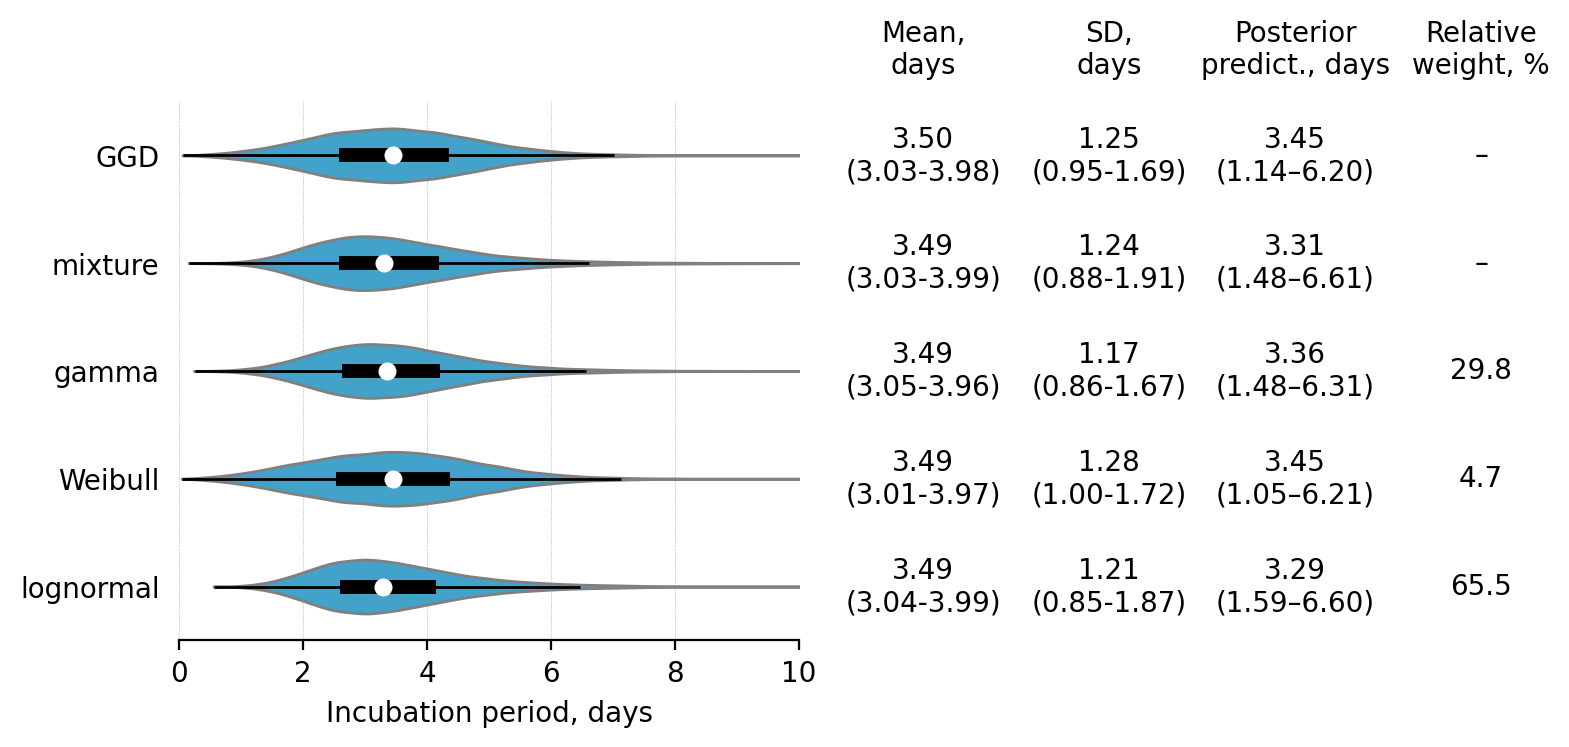

In [42]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, ax = plt.subplots(figsize=(4, 3.5))
ax.set_xlabel('Incubation period, days')

xmx = 10

distribs = ['GGD', 'mixture', 'gamma', 'Weibull', 'lognormal']
# gathering data for violinplots
data_ = None
txt_means = None
txt_sds = None
for idx_distrib, distrib_ in enumerate(distribs):
    df_draws_ = df_draws_Taiwan.loc[lambda d: d['distribution']==distrib_]
    df_draws_.loc[lambda d: d.interval > xmx] = xmx + 1
    vals_ = sorted(df_draws_.interval.values)
    data_ = [vals_] if data_ is None else np.r_[data_, [vals_]] 
    df_fit_ = df_fit_Taiwan.loc[lambda d: d['distribution']==distrib_]
    txt_ = f"{df_fit_.loc[lambda d: d['var']=='mean_interval', 'median'].values[0]:.2f}\n({df_fit_.loc[lambda d: d['var']=='mean_interval', 'lower'].values[0]:.2f}-{df_fit_.loc[lambda d: d['var']=='mean_interval', 'upper'].values[0]:.2f})"
    txt_means = [txt_] if txt_means is None else np.r_[txt_means, [txt_]]
    txt_ = f"{df_fit_.loc[lambda d: d['var']=='sd_interval', 'median'].values[0]:.2f}\n({df_fit_.loc[lambda d: d['var']=='sd_interval', 'lower'].values[0]:.2f}-{df_fit_.loc[lambda d: d['var']=='sd_interval', 'upper'].values[0]:.2f})"
    txt_sds = [txt_] if txt_sds is None else np.r_[txt_sds, [txt_]]
data_ = list(data_)

# plotting
parts = ax.violinplot(data_, vert = False, points=1000,
                        showmeans=False, showmedians=False,
                        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#43a2ca')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)

lower_bounds, quartile1, medians, quartile3, upper_bounds = np.percentile(data_, [2.5, 25, 50, 75, 97.5], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(data_, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(medians, inds, marker='o', color='white', s=30, zorder=3)
ax.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

xtks_step = 2
xtks = np.arange(0, xmx + xtks_step, xtks_step)
for xtk in xtks:
    ax.vlines(xtk, 0, np.max(inds) + 1, color='darkgrey', linestyle=':', lw=.3, zorder=-5)

txt_medians = [f"{mu:.2f}\n({lower:.2f}–{upper:.2f})" for mu, lower, upper in zip(medians, lower_bounds, upper_bounds)]
# for idx_txt, txt in enumerate(txts):
#     ax.text(xmx - .5, inds[idx_txt] - .45, txt, ha='right', va='top', fontsize=9)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xstep = 3
ax.text(xmx - 1 + 4 * xstep, 0.3, 'Relative\nweight, %', ha='center', va='bottom')
ax.text(xmx - 1 + xstep, 0.3, 'Mean,\ndays', ha='center', va='bottom')
ax.text(xmx - 1 + 2 * xstep, 0.3, 'SD,\ndays', ha='center', va='bottom')
ax.text(xmx - 1 + 3 * xstep, 0.3, 'Posterior\npredict., days', ha='center', va='bottom')
# ax.text(-.5, 0.3, 'Composition', ha='right', va='bottom')
for y in range(len(medians)):
    if y >= 2:
        ax.text(xmx - 1 + 4 * xstep, y + 1, f'{mean_weights_Taiwan[y-2]:.1f}', ha='center', va='center', fontsize=10)
    else:
        ax.text(xmx - 1 + 4 * xstep, y + 1, '–', ha='center', va='center', fontsize=10)
    ax.text(xmx - 1 + xstep, y + 1, txt_means[y], ha='center', va='center', fontsize=10)
    ax.text(xmx - 1 + 2 * xstep, y + 1, txt_sds[y], ha='center', va='center', fontsize=10)
    ax.text(xmx - 1 + 3 * xstep, y + 1, txt_medians[y], ha='center', va='center', fontsize=10)

ax.set_xticks(xtks)
ax.set_yticks(inds)
ax.set_yticklabels(distribs)

for idx_ in range(3):
    ax.set_xlim(0, xmx)
    ax.set_ylim(0.5, np.max(inds) + .5)
    ax.yaxis.set_ticks_position('none') 

ax.invert_yaxis()

if save_figures:
    filename_ = "Taiwan_incper_comparison"
    fig.savefig(os.path.join(figuresdir, filename_+".pdf"), format="pdf", bbox_inches="tight")
    fig.savefig(os.path.join(figuresdir, filename_+".tiff"), format="tiff", bbox_inches="tight", dpi=300)

# Wuhan data

In [43]:
%%R -o df_both_obs -o 右截斷日期
libraries = c("dplyr", "tidyr", "ggplot2", "readxl", "lubridate")  
for(x in libraries) { suppressMessages(library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)) }

# the cmdpath should be changed if necessary 
Sys.setlocale("LC_TIME", "C")
'%&%' = function(x,y)paste0(x,y)

R.Version()$version.string

右截斷日 = as.Date("2020-01-31") # right truncation date
mindate = as.Date("2019-12-01")

右截斷日期 = as.numeric(右截斷日 - mindate)

df_inc = read.csv('../../data/data_inc_per_Wuhan_Linton_et_al_JCM2020.csv')  |>
    select(id, exp_l, exp_r, onset, hosp) |>
    # here I translate some columns to Chinese, so it will be correspondent to the code for Taiwan_Omicron
    rename(案號 = id, 首次曝光日 = exp_l, 末次曝光日 = exp_r, 發病日 = onset, 住院治療日 = hosp) |>
    mutate(across(contains("日"), ~as.Date(., format="%Y-%m-%d"))) |>
    # if the onset is not given, then its right end is assigned to the hospitalization date, its left end to the right exposure date
    mutate(首發病日 = if_else(is.na(發病日), 首次曝光日, 發病日), 末發病日 = if_else(is.na(發病日), 住院治療日, 發病日)) |> 
    # if the right exposure is not given, then it is assinged to the right onset date
    mutate(末次曝光日 = if_else(is.na(末次曝光日), 末發病日, 末次曝光日)) |> 
    # lastly, if the right exposure date is later than the right onset date, then it is assigned to the right onset date
    mutate(末次曝光日 = if_else(末次曝光日 > 末發病日, 末發病日, 末次曝光日)) |> 
    # expressing date as days from mindate
    mutate(首次曝光日期 = as.numeric(首次曝光日 - mindate), 末次曝光日期 = as.numeric(末次曝光日 - mindate), 
           首發病日期 = as.numeric(首發病日 - mindate), 末發病日期 = as.numeric(末發病日 - mindate)) |>
    # if exp_r is NA or it is later then the onset date, we assign it to the left onset because it is the data among travellers from Wuhan
    mutate(末次曝光日期 = if_else(末次曝光日期 >= 首發病日期 | is.na(末次曝光日期), 首發病日期, 末次曝光日期)) 
print(paste0("Number of records: ", nrow(df_inc)))
df_both_obs = df_inc |> filter(!is.na(首次曝光日), !is.na(末次曝光日))
df_obs_first = df_inc |> filter(!is.na(首次曝光日), is.na(末次曝光日))
df_obs_last = df_inc |> filter(is.na(首次曝光日), !is.na(末次曝光日))
print(paste0("Censored dfs are empty: nrow(df_obs_first) = ", nrow(df_obs_first), " and nrow(df_obs_last) = ", nrow(df_obs_last)))

[1] "Number of records: 52"
[1] "Censored dfs are empty: nrow(df_obs_first) = 0 and nrow(df_obs_last) = 0"


In [44]:
右截斷日 = pd.to_datetime("2020-01-31", format="%Y-%m-%d")

In [45]:
右截斷日期 = 右截斷日期.astype('int64')[0]
右截斷日期

61

In [46]:
def runSimulation_time_interval_Wuhan(df_inc = df_both_obs, distrib = 'GGD'):
    basename = f'{右截斷日.strftime("%Y%m%d")}_incubation_period_{distrib}-Wuhan'
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)

    stan_code_file = os.path.join(standirname, f'{basename}.stan')
    !cat stan_src/incper-{distrib}.stan > {stan_code_file}

    M_ = 180
    inc_per_max_ = 12

    stan_data = dict({
        'N': df_inc.shape[0],
        'exposureL': np.array(df_inc.首次曝光日期.values, dtype='int'),
        'exposureR': np.array(df_inc.首次曝光日期.values, dtype='int') + 1,
        'onsetL': np.array(df_inc.首發病日期.values, dtype='int'),  
        'onsetR': np.array(df_inc.末發病日期.values, dtype='int') + 1, 
        'truncation_day': [右截斷日期] * df_inc.shape[0],
        'censored': [0] * df_inc.shape[0],
        'M': M_,
        'incper_max': inc_per_max_,
        'mean_prior': 0.0,
        'sd_prior': 2.0
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit = model.sample(data = stan_data_file, seed = 20250131, iter_warmup = num_warmup, iter_sampling = num_iterations, 
                       show_console = False, show_progress = True, chains = num_chains, adapt_delta = 0.999) 
    fit.save_csvfiles(dir=standirname)

    return(fit)

fit_Wuhan_GGD = runSimulation_time_interval_Wuhan(distrib = 'GGD')

11:17:25 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20200131_incubation_period_GGD-Wuhan/20200131_incubation_period_GGD-Wuhan.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20200131_incubation_period_GGD-Wuhan/20200131_incubation_period_GGD-Wuhan
11:17:34 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/20200131_incubation_period_GGD-Wuhan/20200131_incubation_period_GGD-Wuhan
11:17:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:18:49 - cmdstanpy - INFO - CmdStan done processing.
11:18:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: _20200131_incubation_period_GGD_Wuhan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20200131_incubation_period_GGD-Wuhan.stan', line 92, column 4 to column 75)
	Exception: _20200131_incubation_period_GGD_Wuhan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20200131_incubation_period_GGD-Wuhan.stan', line 92, column 4 to column 75)
	Exception: _20200131_incubation_period_GGD_Wuhan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20200131_incubation_period_GGD-Wuhan.stan', line 92, column 4 to column 75)
	Exception: _20200131_incubation_period_GGD_Wuhan_model_namespace::log_prob: sd_interval is nan, but must be greater than or equal to 0.000000 (in '20200131_incubation_period_GGD-Wuhan.stan', line 92, column 

In [47]:
idata_Wuhan = az.from_cmdstanpy(posterior=fit_Wuhan_GGD,
    posterior_predictive=["pred_interval", "x", "pdf"],
    dtypes={"pred_interval": float, "x": float, "pdf": float})

df_pdf_Wuhan = get_stats(idata_Wuhan.posterior_predictive, ['pdf', 'x']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_pdf_Wuhan.loc[lambda d: d['var']=='x', 'median'].values
df_pdf_Wuhan = df_pdf_Wuhan.loc[lambda d: d['var']=='pdf']
df_pdf_Wuhan['x'] = x_

In [48]:
idata_Taiwan = az.from_cmdstanpy(posterior=fit_GGD,
    posterior_predictive=["pred_interval", "x", "pdf"],
    dtypes={"pred_interval": float, "x": float, "pdf": float})

df_pdf_Taiwan = get_stats(idata_Taiwan.posterior_predictive, ['pdf', 'x']).rename(columns={'time':'t', 'q2.5': 'lower', 'q97.5': 'upper'})
x_ = df_pdf_Taiwan.loc[lambda d: d['var']=='x', 'median'].values
df_pdf_Taiwan = df_pdf_Taiwan.loc[lambda d: d['var']=='pdf']
df_pdf_Taiwan['x'] = x_

In [49]:
x_plt_max = 12

clr_Present = '#cb181d'
interpolation_ = 'natural'
base_pdf = alt.Chart(df_pdf_Taiwan.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period, days'))
median_pdf = base_pdf.mark_line(color=clr_Present, interpolate=interpolation_).encode(alt.Y('median'))
lower_pdf = base_pdf.mark_line(color=clr_Present, size=.3, interpolate=interpolation_).encode(alt.Y('lower'))
upper_pdf = base_pdf.mark_line(color=clr_Present, size=.3, interpolate=interpolation_).encode(alt.Y('upper'))
area_pdf = base_pdf.mark_area(interpolate=interpolation_, opacity=.1, color=clr_Present, clip=True).encode(alt.Y('lower'),alt.Y2('upper'))

clr_Wuhan = 'black'
base_pdf_Wuhan = alt.Chart(df_pdf_Wuhan.loc[lambda d: d['x'] <= x_plt_max]).encode(
    alt.X('x', title='Incubation period, days'))
median_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, strokeDash=[4, 3], interpolate=interpolation_).encode(alt.Y('median', title='Probability density'))
lower_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, size=.3, interpolate=interpolation_).encode(alt.Y('lower'))
upper_pdf_Wuhan = base_pdf_Wuhan.mark_line(color=clr_Wuhan, size=.3, interpolate=interpolation_).encode(alt.Y('upper'))
area_pdf_Wuhan = base_pdf_Wuhan.mark_area(interpolate=interpolation_, opacity=.1, color=clr_Wuhan, clip=True).encode(alt.Y('lower'),alt.Y2('upper'))

chart = alt.layer(median_pdf_Wuhan + area_pdf_Wuhan + lower_pdf_Wuhan + upper_pdf_Wuhan, 
                  area_pdf + median_pdf + lower_pdf + upper_pdf
                 ).properties(width=320, height=200).configure_axis(grid=False)

if save_figures:
    save_chart(chart, f'{figuresdir}/Fig_inc_pdf.svg')

chart

alt.LayerChart(...)

In [50]:
mod_inc_summary_output = pd.concat([get_stats(idata_Taiwan.posterior, ['mean_interval', 'sd_interval']),
                                    get_stats(idata_Taiwan.posterior_predictive, ['pred_interval'])], ignore_index = True)
mod_inc_summary_output['Mean (95% CI) [95th percentile]'] = ["%.1f (%.1f-%.1f) [%.1f]" % (x, y, z, w) for (x,y,z,w) in zip(mod_inc_summary_output['mean'], mod_inc_summary_output['q2.5'], mod_inc_summary_output['q97.5'], mod_inc_summary_output['q95'])]
mod_inc_summary_output['Parameter'] = ['Mean incubation period, days', 'SD, days', 'Posterior incubation period, days']

mod_inc_summary_output.loc[lambda d: ~d.Parameter.str.contains("Pr\("), ['Parameter', 'Mean (95% CI) [95th percentile]']]

Parameter Mean (95% CI) [95th percentile]
0       Mean incubation period, days             3.5 (3.0-4.0) [3.9]
1                           SD, days             1.3 (0.9-1.7) [1.6]
2  Posterior incubation period, days             3.5 (1.1-6.2) [5.7]

## 2. Epicurve (based on not publicly available data)

In [3]:
# the following data are not publicly available
%%time
df_linelist = pd.read_excel(os.path.join('../../data', '20220225-Airport staff-linelist.xlsx'), na_values=["NA","","疫調中","無症狀","調查中"]).loc[lambda d: d.確診日<=truncation_date]
print(df_linelist.shape[0])
df_linelist[:2]

821
CPU times: user 143 ms, sys: 23.1 ms, total: 166 ms
Wall time: 810 ms


案號     ID   地區 性別  年齡 是否為突破 性感染 COVID-19疫苗接種        發病日   症狀  \
0  案17058  17058  NaN  男  41       NaN          NaN 2021-12-27  NaN   
1  案17099  17099  NaN  女  34       NaN          NaN 2021-12-28  NaN   

      PCR採檢日  ... Omicron  Removed      Transmission Potential infectors  \
0        NaT  ...       是      NaN  Prevention hotel               17085   
1 2021-12-29  ...       是      NaN  Prevention hotel               17085   

  Relationship   備註 Remarks  \
0          NaN  NaN     NaN   
1          NaN  NaN     NaN   

                                            Source_1  \
0  https://tw.news.yahoo.com/news/%E9%98%B2%E7%96...   
1  https://tw.news.yahoo.com/news/%E9%98%B2%E7%96...   

                                            Source_2 Source_3  
0  https://tw.news.yahoo.com/news/%E9%98%B2%E7%96...      NaN  
1  https://tw.news.yahoo.com/news/%E9%98%B2%E7%96...      NaN  

[2 rows x 28 columns]

In [4]:
df_linelist.columns

Index(['案號', 'ID', '地區', '性別', '年齡', '是否為突破 性感染', 'COVID-19疫苗接種', '發病日', '症狀',
       'PCR採檢日', 'Ct值_1', 'Ct值_2', 'Ct值_3', 'Negative PCR採檢日', 'IgM',
       'Antibody', '確診日', '採檢途徑', 'Omicron', 'Removed', 'Transmission',
       'Potential infectors', 'Relationship', '備註', 'Remarks', 'Source_1',
       'Source_2', 'Source_3'],
      dtype='object')

In [ ]:
df = df_linelist.loc[lambda d: d.Removed!='Yes'].drop(['ID', 'Source_1', 'Source_2', 'Source_3', 'Antibody', 'Remarks', '備註', 'Potential infectors'], axis=1) 
for col in df.columns[df.columns.str.contains("日")]:
    if col != '歸人排序發病日期(新→舊)':
        df[col] = pd.to_datetime(df.loc[:,col], format="%Y-%m-%d")
    else:
        df[col] = df.loc[:,col].astype('Int64')
    df[col + '期'] = (df[col] - mindate).dt.days
print(df.shape)
df = df.loc[lambda d: d.Relationship!='Factory of 18219-18220']
print(df.shape)

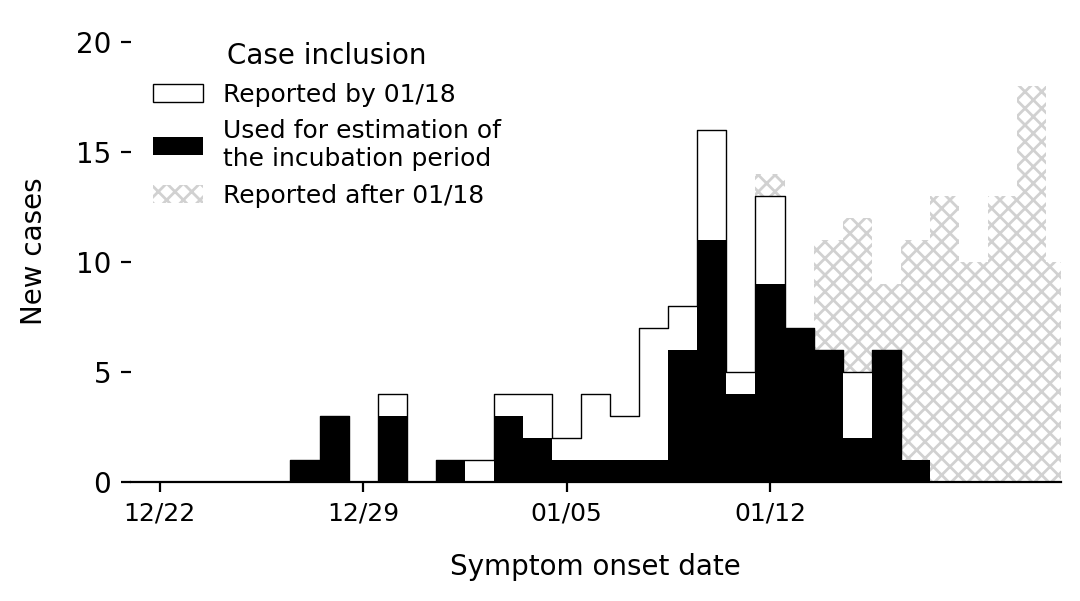

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(6,3); 

xmax = np.timedelta64(右截斷日_inc - mindate,'D').astype('int64') + 5
xmin = np.timedelta64(datemin_plt - mindate,'D').astype('int64')
bins_number = int(xmax)+2

df_ = df.loc[lambda d: d.確診日 <= 右截斷日_inc].copy()
df_inc_ = df_inc.copy()
df_inc_['發病日期'] = [np.timedelta64(onset - mindate, 'D').astype('int64') for onset in df_inc_.發病日]
df_ext_ = df_extended.copy()

n_, edges = np.histogram(df_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='k', facecolor = 'w', label = 'Reported by ' + 右截斷日_inc.strftime("%m/%d"))

n_, edges = np.histogram(df_inc_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0, step='pre', edgecolor='k', facecolor = 'k', label = 'Used for estimation of\nthe incubation period')

n_, _ = np.histogram(df_ext_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-2] + 0.5, [0]*(len(n_)-1), n_[:-1], lw = 0, step='pre', facecolor = 'none', edgecolor='k', alpha=.18, hatch='xxxx', zorder=-4.2, 
                label = 'Reported after ' + 右截斷日_inc.strftime("%m/%d"))

xstep = 5
xtks = np.arange(xmin-3, xmax-5, 7)
ax.set_xticks(xtks)
ax.set_xticklabels([(mindate+np.timedelta64(int(x),'D')).strftime("%m/%d") for x in xtks],fontsize=9);

ax.set_xlabel('Symptom onset date',labelpad=10)
ax.set_ylabel('New cases',labelpad=10)
plt.legend(frameon=False, fontsize=9, ncol=1, title='Case inclusion', title_fontsize=10, loc=2)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.axvline(x=np.timedelta64(右截斷日_inc - mindate, 'D').astype('int64') + 0.5, linestyle='dashed', color='k', linewidth=.8, zorder=15)

plt.axis('tight');
ax.set_yticks(np.arange(0,30,5));
ax.set_ylim(0,21)
ax.set_xlim(xmin-4,xmax-1);

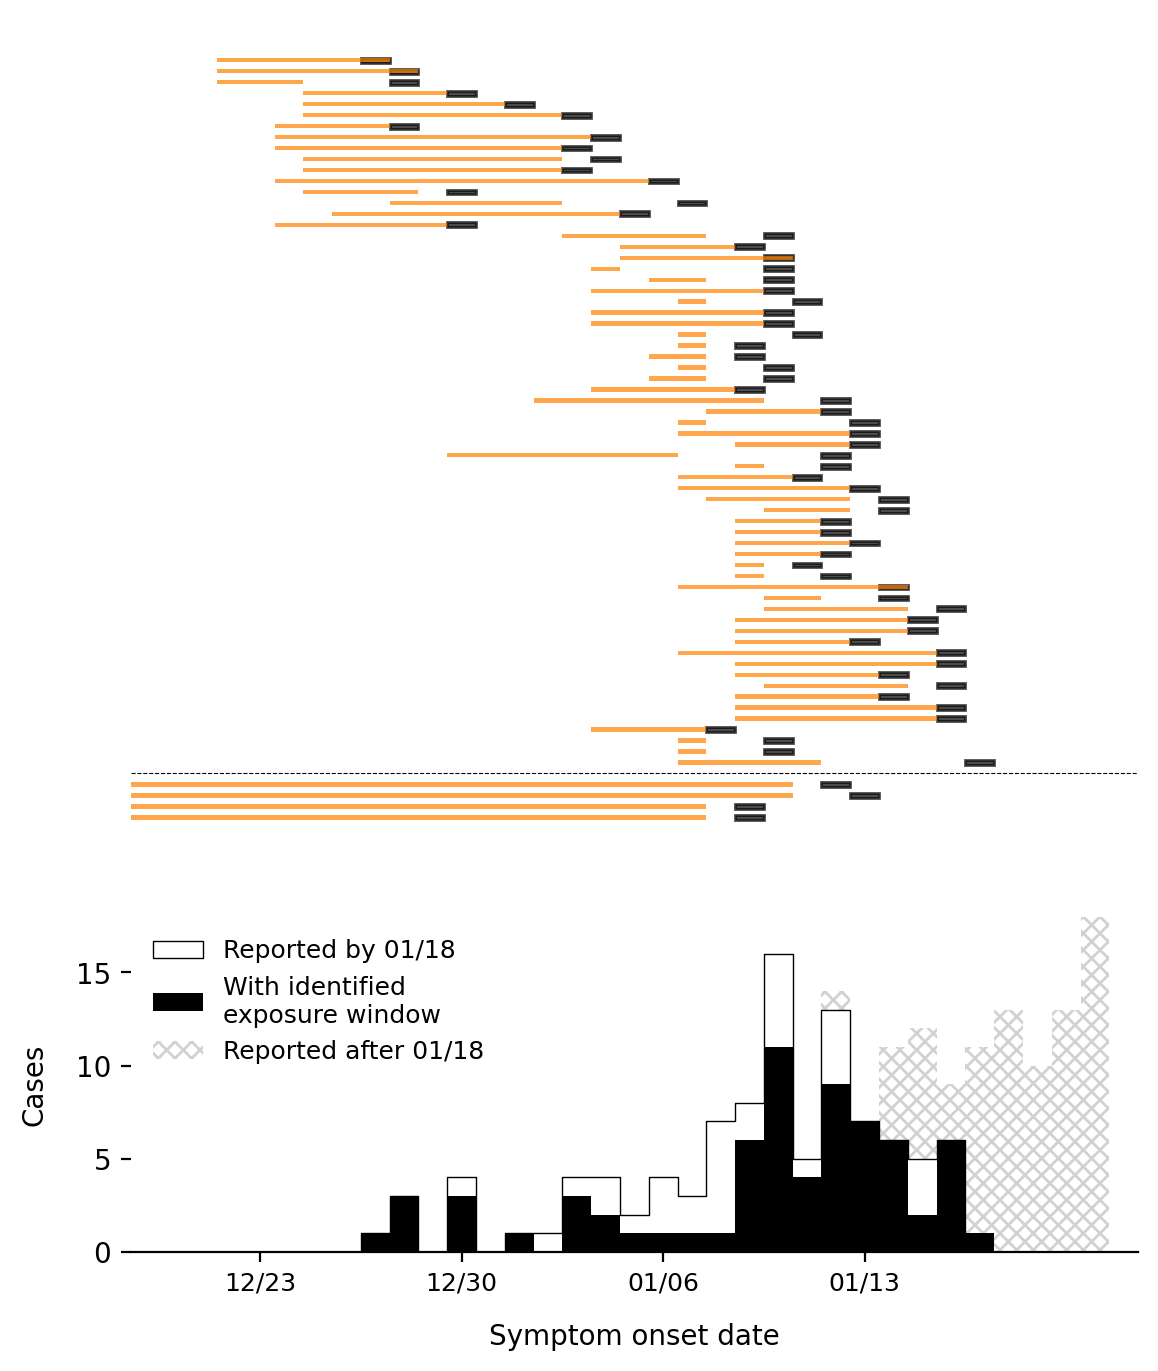

In [52]:
# fig, ax = plt.subplots()
fig, (ax2, ax) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 
                                                              'hspace': 0.1})
fig.set_size_inches(6.5,8); 

xmax = np.timedelta64(右截斷日_inc - mindate,'D').astype('int64') + 4
xmin = np.timedelta64(datemin_plt - mindate,'D').astype('int64') - 6

## First subplot
bins_number = int(xmax)+2

df_ = df.loc[lambda d: d.確診日 <= 右截斷日_inc].copy()
df_inc_ = df_inc.copy()
df_inc_['發病日期'] = [np.timedelta64(onset - mindate, 'D').astype('int64') for onset in df_inc_.發病日]
df_ext_ = df_extended.copy()

n_, edges = np.histogram(df_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0.5, step='pre', edgecolor='k', facecolor = 'w', label = 'Reported by ' + 右截斷日_inc.strftime("%m/%d"))

n_, edges = np.histogram(df_inc_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-1] + 0.5, n_, lw = 0, step='pre', edgecolor='k', facecolor = 'k', label = 'With identified\nexposure window')

n_, _ = np.histogram(df_ext_.發病日期.values, bins=xmax-xmin+1, range=(xmin, xmax+1))
ax.fill_between(edges[:-2] + 0.5, [0]*(len(n_)-1), n_[:-1], lw = 0, step='pre', facecolor = 'none', edgecolor='k', alpha=.18, hatch='xxxx', zorder=-4.2, 
                label = 'Reported after ' + 右截斷日_inc.strftime("%m/%d"))

xstep = 5
xtks = np.arange(xmin-3, xmax-5, 7)
ax.set_xticks(xtks)
ax.set_xticklabels([(mindate+np.timedelta64(int(x),'D')).strftime("%m/%d") for x in xtks],fontsize=9);

ax.set_xlabel('Symptom onset date',labelpad=10)
ax.set_ylabel('Cases',labelpad=10)
plt.legend(frameon=False, fontsize=9, ncol=1, title=None, title_fontsize=9, loc=2)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks(np.arange(0,30,5));
ax.set_ylim(0,21)
ax.margins(0.0)

## Second subplot
df_ = df_inc.copy()#.sort_values('發病日')
for col in ['首次曝光日', '末次曝光日', '發病日']:
    df_[col + '期'] = [np.timedelta64(x - mindate, 'D').astype('int64') if not pd.isnull(x) else xmin for x in df_[col].values]

ystep = 1
yheight = .4
y_ = 0.0
fct_ = 1.1
from matplotlib.patches import Polygon
for idx in range(df_.shape[0]):
    record_ = df_.iloc[idx]
    x_ = record_.發病日期 - .5
    pts = np.array([[x_, y_-fct_*yheight/2], [x_+1,y_-fct_*yheight/2], [x_+1, y_+fct_*yheight/2], [x_, y_+fct_*yheight/2]])
    ax2.add_patch(Polygon(pts, closed=True, color='k', alpha=.7))

    x1_ = record_.首次曝光日期 - .5
    x2_ = record_.末次曝光日期 - .5
    pts = np.array([[x1_, y_-yheight/2], [x2_+1,y_-yheight/2], [x2_+1, y_+yheight/2], [x1_, y_+yheight/2]])
    if idx < N_inc_observed:
        ax2.add_patch(Polygon(pts, closed=True, facecolor='#ff7f00', edgecolor='none', alpha=.7, linewidth=.4))
    else:
        ax2.add_patch(Polygon(pts, closed=False, facecolor='#ff7f00', edgecolor='none', alpha=.7, linewidth=.4))
    if idx == N_inc_observed - 1:
        y_ -= ystep
    y_ -= ystep
    
# ax2.set_xlabel('Symptom onset date',labelpad=10)

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.axhline(y=-ystep*N_inc_observed, linestyle='dashed', color='k', linewidth=.4, zorder=15)

# ax2.set_xticklabels([])
ax2.tick_params('x', length=0)
ax2.set_yticks([])
ax2.set_xlim(xmin,xmax);

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-incper_BA1.pdf", format="pdf", bbox_inches="tight");

plt.axis('tight');

## 3. Meta-analysis

In [70]:
litsearch_folder = '../../data/lit_search_incper'
df_inc_review = pd.read_excel(os.path.join(litsearch_folder, '20240819_litsearch_final.xlsx')).reset_index(drop=True)
df_inc_review.columns

Index(['database_index', 'Title', 'Authors', 'Citation', 'Publication Year',
       'Create Date', 'Abstract', 'PMID', 'DOI', 'PMID_DOI', 'database',
       'Selection', 'Reason for exclusion', 'Remarks'],
      dtype='object')

In [71]:
df_inc_review = pd.read_excel(os.path.join(litsearch_folder, '20240819_litsearch_final.xlsx'), sheet_name='Results').reset_index(drop=True)\
    .loc[lambda d: d.Variant!='Delta']
df_inc_review.columns

Index(['Study', 'Publication date', 'Variant', 'Cases', 'Mean', 'Mean_lower',
       'Mean_upper', 'SD', 'Distribution', 'score', 'url', 'Remarks'],
      dtype='object')

In [72]:
print("Analyzed studies:", df_inc_review.Study.drop_duplicates().shape[0])
print("which resulted in", df_inc_review.shape[0], "records")

Analyzed studies: 21
which resulted in 28 records


In [73]:
df_inc_review.groupby('Variant')['Variant'].count()

Variant
Omicron BA.1    17
Omicron BA.2     7
Omicron BA.5     4
Name: Variant, dtype: int64

In [74]:
from scipy import stats

In [75]:
df_inc_review_analyzed = df_inc_review.copy().reset_index(drop=True).drop('url', axis=1).sort_values('Publication date')
# df_inc_review_analyzed['Study'] = [x.split(' ')[0] + ' et al. ' + str(y) for x, y in zip(df_inc_review_analyzed['First Author'], df_inc_review_analyzed['Publication Year'])]
# df_inc_review_analyzed = df_inc_review_analyzed.loc[:, ['Study', 'Create Date', 'Subvariant', 'Mean', 'Mean_lower', 'Mean_upper', 'SD', 'CohortSize']]
df_inc_review_analyzed['Mean_lower'] = [mean_lower if ~np.isnan(mean_lower) else mean + stats.t.ppf(0.025, N - 1) * sd / np.sqrt(N) for mean, mean_lower, sd, N in zip(df_inc_review_analyzed['Mean'], df_inc_review_analyzed['Mean_lower'], df_inc_review_analyzed['SD'], df_inc_review_analyzed['Cases'])]
df_inc_review_analyzed['Mean_upper'] = [mean_upper if ~np.isnan(mean_upper) else mean + stats.t.ppf(0.975, N - 1) * sd / np.sqrt(N) for mean, mean_upper, sd, N in zip(df_inc_review_analyzed['Mean'], df_inc_review_analyzed['Mean_upper'], df_inc_review_analyzed['SD'], df_inc_review_analyzed['Cases'])]
df_inc_review_analyzed['Mean_stderr'] = [(mean_upper - mean_lower) / stats.t.ppf(0.975, N - 1) / np.sqrt(N) / 2 for mean_lower, mean_upper, N in zip(df_inc_review_analyzed['Mean_lower'], df_inc_review_analyzed['Mean_upper'], df_inc_review_analyzed['Cases'])]
df_inc_review_analyzed['Mean_stderr_from_SD'] = [sd / np.sqrt(N) for sd, N in zip(df_inc_review_analyzed['SD'], df_inc_review_analyzed['Cases'])]

df_inc_review_analyzed

Study Publication date       Variant   Cases  Mean  \
25          Helmsdal et al 2022       2022-02-03  Omicron BA.1      21  3.82   
18            Backer et al 2022       2022-02-10  Omicron BA.1     258  3.20   
17            Tanaka et al 2022       2022-05-23  Omicron BA.1      77  3.03   
23  Del Águila-Mejía et al 2022       2022-06-01  Omicron BA.1     333  3.10   
16            Manica et al 2023       2022-08-21  Omicron BA.1      80  3.49   
20            Mefsin et al 2022       2022-09-01  Omicron BA.2      23  4.03   
19            Mefsin et al 2022       2022-09-01  Omicron BA.1      57  4.58   
21             Liu Y et al 2022       2022-12-01  Omicron BA.1      22  3.50   
15               Xin et al 2023       2022-12-13  Omicron BA.1     114  3.80   
27              Ward et al 2022       2022-12-20  Omicron BA.2    8785  3.48   
26              Ward et al 2022       2022-12-20  Omicron BA.1  116163  3.67   
22             Xiong et al 2022       2023-02-01  Omicron BA.5     500  3.27   
14               Wei et al 2023       2023-02-05  Omicron BA.2      52  4.60   
13             Ogata et al 2023       2023-03-01  Omicron BA.5     122  2.60   
12             Ogata et al 2023       2023-03-01  Omicron BA.1      68  2.90   
11               Guo et al 2023       2023-03-09  Omicron BA.2     392  3.20   
10               Guo et al 2023       2023-03-09  Omicron BA.1     257  3.60   
9               Wang et al 2023       2023-03-30  Omicron BA.5      60  5.70   
8               Zeng et al 2023       2023-04-01  Omicron BA.1      36  2.80   
6           Galmiche et al 2023       2023-04-18  Omicron BA.1    2682  3.58   
7               Park et al 2023       2023-05-22  Omicron BA.1     258  4.20   
5                Liu et al 2023       2023-09-01  Omicron BA.2     590  4.17   
4                Liu et al 2023       2023-09-01  Omicron BA.1      21  4.85   
3             Russel et al 2024       2024-01-30  Omicron BA.2      60  4.50   
2             Russel et al 2024       2024-01-30  Omicron BA.1      63  5.00   
1                 Li et al 2024       2024-03-06  Omicron BA.2     345  3.39   
0                 Li et al 2024       2024-03-06  Omicron BA.1      75  3.42   
24           Overton et al 2024       2024-07-22  Omicron BA.5    1405  2.52   

    Mean_lower  Mean_upper    SD Distribution  score  Remarks  Mean_stderr  \
25    3.460000    4.190000   NaN          NaN      3      NaN     0.038184   
18    2.900000    3.600000   NaN        gamma      3      NaN     0.011065   
17    2.730000    3.300000   NaN    lognormal      5      NaN     0.016307   
23    2.820000    3.380000   NaN          NaN      4      NaN     0.007800   
16    3.190000    3.770000  1.20        gamma      5      NaN     0.016289   
20    3.190000    4.800000   NaN      Weibull      5      NaN     0.080938   
19    4.100000    5.080000   NaN        gamma      5      NaN     0.032399   
21    2.500000    3.800000   NaN        gamma      5      NaN     0.066638   
15    3.500000    4.100000   NaN        gamma      6      NaN     0.014182   
27    3.430000    3.530000   NaN    lognormal      5      NaN     0.000272   
26    3.610000    3.720000   NaN    lognormal      5      NaN     0.000082   
22    3.070000    3.450000   NaN    lognormal      6      NaN     0.004325   
14    4.015356    5.184644  2.10      Weibull      4      NaN     0.040385   
13    2.500000    2.800000   NaN        gamma      4      NaN     0.006860   
12    2.600000    3.200000   NaN        gamma      4      NaN     0.018227   
11    2.800000    3.700000   NaN        gamma      6      NaN     0.011560   
10    2.300000    5.400000   NaN        gamma      6      NaN     0.049097   
9     4.800000    6.600000   NaN        gamma      6      NaN     0.058066   
8     0.770000    6.990000   NaN        gamma      5      NaN     0.255323   
6     3.520000    3.650000  1.77        gamma      0      NaN     0.000640   
7     3.600000    4.900000   NaN        gamma      5      NaN     0

In [76]:
df_inc_review_analyzed.columns

Index(['Study', 'Publication date', 'Variant', 'Cases', 'Mean', 'Mean_lower',
       'Mean_upper', 'SD', 'Distribution', 'score', 'Remarks', 'Mean_stderr',
       'Mean_stderr_from_SD'],
      dtype='object')

In [77]:
print("Insufficient information:", df_inc_review_analyzed.loc[lambda d: np.isnan(d.Mean_stderr)].shape[0])

Insufficient information: 0


In [78]:
df_inc_review_analyzed = df_inc_review_analyzed.loc[lambda d: ~np.isnan(d.Mean_stderr)]
df_inc_review_analyzed['Cases'] = df_inc_review_analyzed['Cases'].astype('int64')
df_inc_review_analyzed

Study Publication date       Variant   Cases  Mean  \
25          Helmsdal et al 2022       2022-02-03  Omicron BA.1      21  3.82   
18            Backer et al 2022       2022-02-10  Omicron BA.1     258  3.20   
17            Tanaka et al 2022       2022-05-23  Omicron BA.1      77  3.03   
23  Del Águila-Mejía et al 2022       2022-06-01  Omicron BA.1     333  3.10   
16            Manica et al 2023       2022-08-21  Omicron BA.1      80  3.49   
20            Mefsin et al 2022       2022-09-01  Omicron BA.2      23  4.03   
19            Mefsin et al 2022       2022-09-01  Omicron BA.1      57  4.58   
21             Liu Y et al 2022       2022-12-01  Omicron BA.1      22  3.50   
15               Xin et al 2023       2022-12-13  Omicron BA.1     114  3.80   
27              Ward et al 2022       2022-12-20  Omicron BA.2    8785  3.48   
26              Ward et al 2022       2022-12-20  Omicron BA.1  116163  3.67   
22             Xiong et al 2022       2023-02-01  Omicron BA.5     500  3.27   
14               Wei et al 2023       2023-02-05  Omicron BA.2      52  4.60   
13             Ogata et al 2023       2023-03-01  Omicron BA.5     122  2.60   
12             Ogata et al 2023       2023-03-01  Omicron BA.1      68  2.90   
11               Guo et al 2023       2023-03-09  Omicron BA.2     392  3.20   
10               Guo et al 2023       2023-03-09  Omicron BA.1     257  3.60   
9               Wang et al 2023       2023-03-30  Omicron BA.5      60  5.70   
8               Zeng et al 2023       2023-04-01  Omicron BA.1      36  2.80   
6           Galmiche et al 2023       2023-04-18  Omicron BA.1    2682  3.58   
7               Park et al 2023       2023-05-22  Omicron BA.1     258  4.20   
5                Liu et al 2023       2023-09-01  Omicron BA.2     590  4.17   
4                Liu et al 2023       2023-09-01  Omicron BA.1      21  4.85   
3             Russel et al 2024       2024-01-30  Omicron BA.2      60  4.50   
2             Russel et al 2024       2024-01-30  Omicron BA.1      63  5.00   
1                 Li et al 2024       2024-03-06  Omicron BA.2     345  3.39   
0                 Li et al 2024       2024-03-06  Omicron BA.1      75  3.42   
24           Overton et al 2024       2024-07-22  Omicron BA.5    1405  2.52   

    Mean_lower  Mean_upper    SD Distribution  score  Remarks  Mean_stderr  \
25    3.460000    4.190000   NaN          NaN      3      NaN     0.038184   
18    2.900000    3.600000   NaN        gamma      3      NaN     0.011065   
17    2.730000    3.300000   NaN    lognormal      5      NaN     0.016307   
23    2.820000    3.380000   NaN          NaN      4      NaN     0.007800   
16    3.190000    3.770000  1.20        gamma      5      NaN     0.016289   
20    3.190000    4.800000   NaN      Weibull      5      NaN     0.080938   
19    4.100000    5.080000   NaN        gamma      5      NaN     0.032399   
21    2.500000    3.800000   NaN        gamma      5      NaN     0.066638   
15    3.500000    4.100000   NaN        gamma      6      NaN     0.014182   
27    3.430000    3.530000   NaN    lognormal      5      NaN     0.000272   
26    3.610000    3.720000   NaN    lognormal      5      NaN     0.000082   
22    3.070000    3.450000   NaN    lognormal      6      NaN     0.004325   
14    4.015356    5.184644  2.10      Weibull      4      NaN     0.040385   
13    2.500000    2.800000   NaN        gamma      4      NaN     0.006860   
12    2.600000    3.200000   NaN        gamma      4      NaN     0.018227   
11    2.800000    3.700000   NaN        gamma      6      NaN     0.011560   
10    2.300000    5.400000   NaN        gamma      6      NaN     0.049097   
9     4.800000    6.600000   NaN        gamma      6      NaN     0.058066   
8     0.770000    6.990000   NaN        gamma      5      NaN     0.255323   
6     3.520000    3.650000  1.77        gamma      0      NaN     0.000640   
7     3.600000    4.900000   NaN        gamma      5      NaN     0

### All studies

#### No pooling

In [79]:
df_meta_incper_summary = None
for Omicron_variant_ in ['BA.1', 'BA.2', 'BA.5']:
    basename = f'incper_{Omicron_variant_}_meta_summary'
    standirname = os.path.join(mainstandirname, basename)
    
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)

    stan_code_file = os.path.join(standirname, f'{basename}.stan')
    !cat stan_src/meta.stan > {stan_code_file}

    df_ = df_inc_review_analyzed.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()
    
    stan_data = dict({
        'J': df_.shape[0],
        'mu_known': df_['Mean'].values,
        'stderr_known': df_['Mean_stderr'].values
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit_meta = model.sample(data = stan_data_file, seed = 1, iter_warmup = num_warmup, iter_sampling = num_iterations,
                       show_console = False, show_progress = True, chains = num_chains, adapt_delta = 0.99) 
    fit_meta.save_csvfiles(dir = standirname)

    df_meta_ = get_stats(fit_meta, ['mu', 'tau_squared'])
    df_meta_['Variant'] = f'Omicron {Omicron_variant_}'
    df_meta_incper_summary = df_meta_ if df_meta_incper_summary is None else pd.concat([df_meta_incper_summary, df_meta_], ignore_index=True)

15:14:20 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary/incper_BA.1_meta_summary.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary/incper_BA.1_meta_summary
15:14:25 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary/incper_BA.1_meta_summary
15:14:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:14:26 - cmdstanpy - INFO - CmdStan done processing.


15:14:26 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary/incper_BA.2_meta_summary.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary/incper_BA.2_meta_summary
15:14:31 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary/incper_BA.2_meta_summary
15:14:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:14:31 - cmdstanpy - INFO - CmdStan done processing.


15:14:32 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary/incper_BA.5_meta_summary.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary/incper_BA.5_meta_summary
15:14:36 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary/incper_BA.5_meta_summary
15:14:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:14:37 - cmdstanpy - INFO - CmdStan done processing.


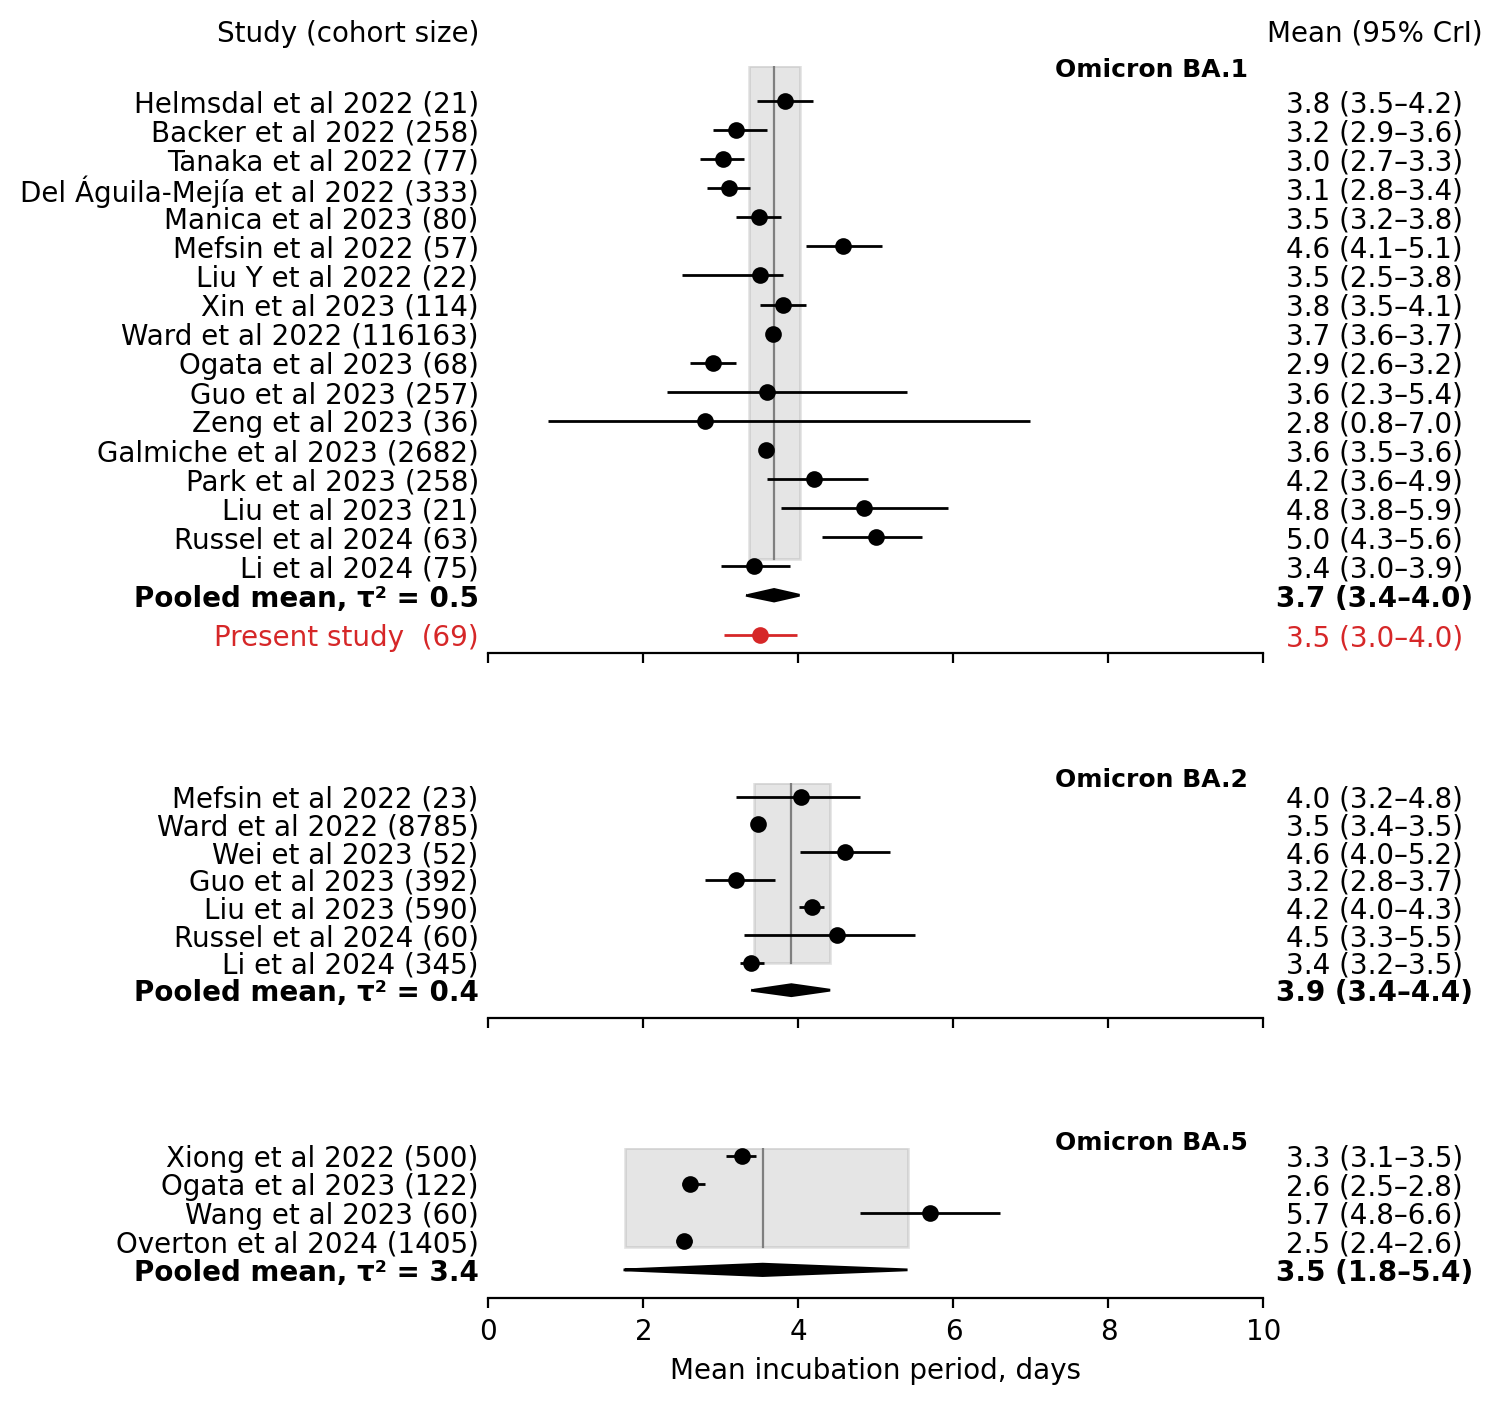

In [80]:
fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [3.5, 1.4, .9], 'hspace': .4})

xmx = 10
cpsz = 0
ymn_ = [.16, .235, .34]
clr_curr_ = 'C3'
clr_ = 'C7'

fig.set_size_inches(5, 8); 

for idx, Omicron_variant_ in enumerate(['BA.1', 'BA.2', 'BA.5']):
    ax = axs[idx]
    df_ = df_inc_review_analyzed.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()[::-1]

    df_['Source'] = df_['Study']
    df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['Cases'])]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

    ax.errorbar(x=list(df_['Mean']), 
                y = df_['Source_y'], 
                xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], 
                color='black', capsize=cpsz,
                linestyle='None', linewidth=1, markersize=0)
    ax.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
            linestyle='None', linewidth=1, marker="o", ms=5)

    # Pooled mean
    df_meta_incper_summary_ = df_meta_incper_summary.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()
    mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    
    y_ = 0.0
    h_ = 0.2/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax.add_patch(p)

    ax.axvline(x = mean_meta, ymin = ymn_[idx], linestyle='solid', lw = .8, color=clr_, zorder=-20)
    ax.axvspan(xmin = lower_meta, xmax = upper_meta, ymin = ymn_[idx], zorder = -21, color=clr_, alpha = .2)

    ## current study
    y__ = -0.08
    if (idx == 0):
        df__ = df_current_study.copy()
        df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['Cases'])]
    
        ax.errorbar(x = list(df__['mu']), y = y__, 
                    xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_curr_, capsize=cpsz,
                    linestyle='None', linewidth=1, markersize=0)
        ax.plot(list(df__['mu']), y__, color=clr_curr_, linestyle='None', linewidth=1, marker="o", ms=5)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left = 0, right=xmx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if (idx == 0):
        ax.set_ylim(-2./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )
    else:
        ax.set_ylim(-1./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}']])

    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(ax.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
    if (idx == 0):
        df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
    else:
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})']], ha='center', fontsize=10)
        
    ax2.yaxis.set_tick_params(pad=40)

    [[label.set_fontweight('bold')] if 'Pool' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    [label.set_color(clr_curr_) if 'Present' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_color(clr_curr_) if 'Present' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    if (idx == 0):
        ax.text(-3.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
        ax.text(xmx + .04, 1.12, 'Mean (95% CrI)', horizontalalignment='left', fontsize=10)

    ax.text(xmx * .98, 1.05, f'Omicron {Omicron_variant_}', 
            horizontalalignment='right', fontsize=9, fontweight='bold', color='k')
    
axs[-1].set_xlabel("Mean incubation period, days")
        
plt.show()

#### With pooling across Omicron variants

In [81]:
df_variants_idxs = pd.DataFrame({'Variant': df_inc_review_analyzed.Variant.drop_duplicates().values}).reset_index().rename(columns = {'index': 'Variant_idx'})
df_variants_idxs.Variant_idx += 1
df_variants_idxs

Variant_idx       Variant
0            1  Omicron BA.1
1            2  Omicron BA.2
2            3  Omicron BA.5

In [82]:
basename = f'incper_meta_with_pooling_summary'
standirname = os.path.join(mainstandirname, basename)
    
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_code_file = os.path.join(standirname, f'{basename}.stan')
!cat stan_src/meta_with_pooling.stan > {stan_code_file}

df_ = df_inc_review_analyzed.copy().merge(df_variants_idxs, how='left')

stan_data = dict({
    'J': df_.shape[0],
    'mu_known': df_['Mean'].values,
    'stderr_known': df_['Mean_stderr'].values,
    'V': len(df_.Variant.drop_duplicates().values),
    'variant': df_.Variant_idx.values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit_meta = model.sample(data = stan_data_file, seed = 1, iter_warmup = 4 * num_warmup, iter_sampling = num_iterations,
                   show_console = False, show_progress = True, chains = num_chains, max_treedepth = 14, adapt_delta = 0.9999) 
fit_meta.save_csvfiles(dir = standirname)

df_meta_with_pooling = get_stats(fit_meta, ['mu', 'mu_overall', 'tau_squared', 'tau_squared_overall'])
df_meta_with_pooling

15:14:38 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary/incper_meta_with_pooling_summary.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary/incper_meta_with_pooling_summary
15:14:44 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary/incper_meta_with_pooling_summary
15:14:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:14:49 - cmdstanpy - INFO - CmdStan done processing.
15:14:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (0.1%)
	Chain 2 had 3 divergent transitions (0.0%)
	Chain 3 had 2 divergent transitions (0.0%)
	Chain 4 had 3 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


var time     mean   hdi2.5    hdi25    hdi75  hdi97.5  \
0                   mu    1  3.71785  3.42723  3.62318  3.81579  4.01380   
1                   mu    2  3.82093  3.45502  3.68545  3.92515  4.21920   
2                   mu    3  3.71703  2.96901  3.57864  3.90305  4.35932   
3           mu_overall   NA  3.75123  3.17704  3.62237  3.88709  4.31753   
4          tau_squared    1  0.45146  0.18386  0.28482  0.46736  0.80297   
5          tau_squared    2  0.40903  0.08451  0.15983  0.36410  0.95269   
6          tau_squared    3  2.49883  0.34953  0.66038  1.88209  6.60216   
7  tau_squared_overall   NA  0.18187  0.00000  0.00000  0.03709  0.69847   

      q2.5      q25   median      q75      q95    q97.5     ess_bulk  \
0  3.41867  3.62214  3.71926  3.81488  3.95791  4.00711  56579.50253   
1  3.45268  3.69825  3.81530  3.93865  4.14226  4.21791  49331.66677   
2  2.96900  3.56380  3.73307  3.88926  4.20617  4.35918  37116.97848   
3  3.16424  3.62093  3.75425  3.88588  4.16237  4.30750  17565.24626   
4  0.21922  0.32805  0.41363  0.53037  0.78834  0.91134  39074.17491   
5  0.12541  0.22894  0.32649  0.48444  0.94360  1.18843  36861.72287   
6  0.57863  1.13433  1.73743  2.83098  6.55724  8.96414  35904.54039   
7  0.00009  0.00760  0.03709  0.13046  0.69844  1.22417  15992.55629   

      ess_tail    r_hat  
0  40599.62087  1.00006  
1  39969.43190  1.00017  
2  34053.00501  1.00005  
3  14063.08866  1.00009  
4  29047.30637  1.00009  
5  27515.01342  1.00010  
6  23972.67300  1.00018  
7  17928.77639  1.00032

In [83]:
df_meta_with_pooling.rename(columns={'time': 'Variant_idx'}).merge(df_variants_idxs, how='left')

var Variant_idx     mean   hdi2.5    hdi25    hdi75  \
0                   mu           1  3.71785  3.42723  3.62318  3.81579   
1                   mu           2  3.82093  3.45502  3.68545  3.92515   
2                   mu           3  3.71703  2.96901  3.57864  3.90305   
3           mu_overall          NA  3.75123  3.17704  3.62237  3.88709   
4          tau_squared           1  0.45146  0.18386  0.28482  0.46736   
5          tau_squared           2  0.40903  0.08451  0.15983  0.36410   
6          tau_squared           3  2.49883  0.34953  0.66038  1.88209   
7  tau_squared_overall          NA  0.18187  0.00000  0.00000  0.03709   

   hdi97.5     q2.5      q25   median      q75      q95    q97.5     ess_bulk  \
0  4.01380  3.41867  3.62214  3.71926  3.81488  3.95791  4.00711  56579.50253   
1  4.21920  3.45268  3.69825  3.81530  3.93865  4.14226  4.21791  49331.66677   
2  4.35932  2.96900  3.56380  3.73307  3.88926  4.20617  4.35918  37116.97848   
3  4.31753  3.16424  3.62093  3.75425  3.88588  4.16237  4.30750  17565.24626   
4  0.80297  0.21922  0.32805  0.41363  0.53037  0.78834  0.91134  39074.17491   
5  0.95269  0.12541  0.22894  0.32649  0.48444  0.94360  1.18843  36861.72287   
6  6.60216  0.57863  1.13433  1.73743  2.83098  6.55724  8.96414  35904.54039   
7  0.69847  0.00009  0.00760  0.03709  0.13046  0.69844  1.22417  15992.55629   

      ess_tail    r_hat       Variant  
0  40599.62087  1.00006  Omicron BA.1  
1  39969.43190  1.00017  Omicron BA.2  
2  34053.00501  1.00005  Omicron BA.5  
3  14063.08866  1.00009           NaN  
4  29047.30637  1.00009  Omicron BA.1  
5  27515.01342  1.00010  Omicron BA.2  
6  23972.67300  1.00018  Omicron BA.5  
7  17928.77639  1.00032           NaN

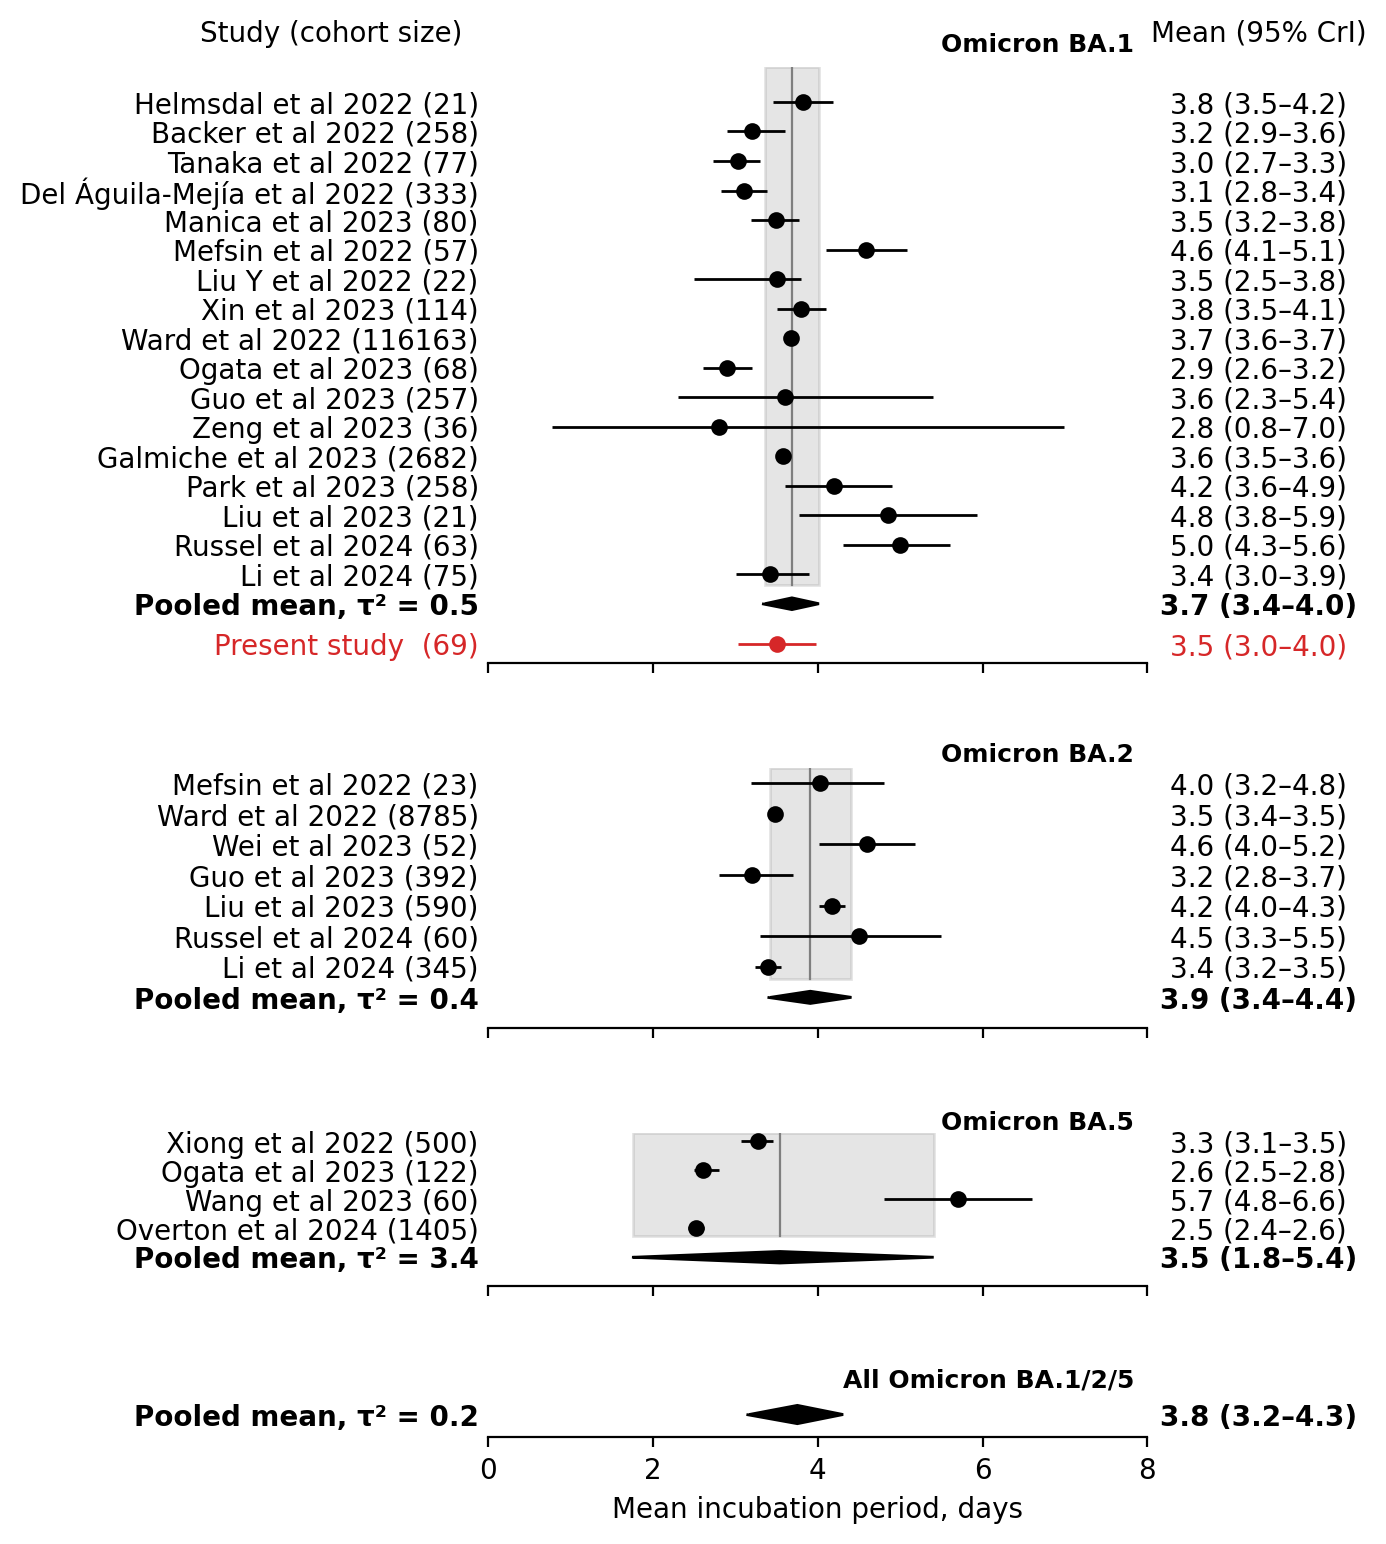

In [84]:
fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3.9, 1.7, 1, .3], 'hspace': .4})

xmx = 8
cpsz = 0
ymn_ = [.13, .19, .33]
clr_curr_ = 'C3'
clr_ = 'C7'

fig.set_size_inches(4.25, 8.9); 

for idx, Omicron_variant_ in enumerate(['BA.1', 'BA.2', 'BA.5']):
    ax = axs[idx]
    df_ = df_inc_review_analyzed.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()[::-1]

    df_['Source'] = df_['Study']
    df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['Cases'])]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

    ax.errorbar(x=list(df_['Mean']), 
                y = df_['Source_y'], 
                xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], 
                color='black', capsize=cpsz,
                linestyle='None', linewidth=1, markersize=0)
    ax.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
            linestyle='None', linewidth=1, marker="o", ms=5)

    # Pooled mean
    # df_meta_incper_summary_ = df_meta_with_pooling.rename(columns={'time': 'Variant_idx'}).merge(df_variants_idxs, how='left').loc[lambda d: d['Variant'] == f'Omicron {Omicron_variant_}']
    df_meta_incper_summary_ = df_meta_incper_summary.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()
    mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    
    y_ = 0.0
    h_ = 0.2/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax.add_patch(p)

    ax.axvline(x = mean_meta, ymin = ymn_[idx], linestyle='solid', lw = .8, color=clr_, zorder=-20)
    ax.axvspan(xmin = lower_meta, xmax = upper_meta, ymin = ymn_[idx], zorder = -21, color=clr_, alpha = .2)

    ## current study
    y__ = -0.08
    if (idx == 0):
        df__ = df_current_study.copy()
        df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['Cases'])]
    
        ax.errorbar(x = list(df__['mu']), y = y__, 
                    xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_curr_, capsize=cpsz,
                    linestyle='None', linewidth=1, markersize=0)
        ax.plot(list(df__['mu']), y__, color=clr_curr_, linestyle='None', linewidth=1, marker="o", ms=5)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left = 0, right=xmx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if (idx == 0):
        ax.set_ylim(-2./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )
    else:
        ax.set_ylim(-1./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}']])

    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(ax.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
    if (idx == 0):
        df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
    else:
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})']], ha='center', fontsize=10)
        
    ax2.yaxis.set_tick_params(pad=40)

    [[label.set_fontweight('bold')] if 'Pool' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    [label.set_color(clr_curr_) if 'Present' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_color(clr_curr_) if 'Present' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    if (idx == 0):
        ax.text(-3.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
        ax.text(xmx + .04, 1.12, 'Mean (95% CrI)', horizontalalignment='left', fontsize=10)

    ax.text(xmx * .98, 1.1, f'Omicron {Omicron_variant_}', 
            horizontalalignment='right', fontsize=9, fontweight='bold', color='k')

# Overall meta
ax = axs[-1]
df_meta_incper_summary_ = df_meta_with_pooling.copy()
mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'mean'].values[0]
lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'q2.5'].values[0]
upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'q97.5'].values[0]
τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared_overall', 'mean'].values[0]

y_ = 0.5
h_ = 0.2
from matplotlib.patches import Polygon
pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
p = Polygon(pts, closed=False, color='k')
ax.add_patch(p)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.spines['right'].set_visible(False)
ax.set_xlim(left = 0, right=xmx)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(0, xmx + 2, 2))
ax.set_yticks([y_])
ax.set_yticklabels([f'Pooled mean, τ² = {τsqr_meta:.1f}'])

ax2 = ax.secondary_yaxis("right")
ax2.set_yticks(ax.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(length=0)
ax2.set_yticklabels([f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], ha='center', fontsize=10, fontweight='bold')
ax2.yaxis.set_tick_params(pad=40)

ax.text(xmx * .98, 1.1, f'All Omicron BA.1/2/5', 
        horizontalalignment='right', fontsize=9, fontweight='bold', color='k')
[label.set_fontweight('bold') for label in ax.get_yticklabels()]

axs[-1].set_xlabel("Mean incubation period, days")

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-incper_meta_with_overall_pooled.pdf", format="pdf", bbox_inches="tight");
        
plt.show()

### Only studies with high assesment scores (4+ out of 6)

#### No pooling

In [87]:
df_meta_incper_summary = None
for Omicron_variant_ in ['BA.1', 'BA.2', 'BA.5']:
    basename = f'incper_{Omicron_variant_}_meta_summary_high_score'
    standirname = os.path.join(mainstandirname, basename)
    
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)

    stan_code_file = os.path.join(standirname, f'{basename}.stan')
    !cat stan_src/meta.stan > {stan_code_file}

    df_ = df_inc_review_analyzed.loc[lambda d: (d.Variant==f'Omicron {Omicron_variant_}') & (d.score >= 4)].copy()
    
    stan_data = dict({
        'J': df_.shape[0],
        'mu_known': df_['Mean'].values,
        'stderr_known': df_['Mean_stderr'].values
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit_meta = model.sample(data = stan_data_file, seed = 1, iter_warmup = num_warmup, iter_sampling = num_iterations,
                       show_console = False, show_progress = True, chains = num_chains, adapt_delta = 0.99) 
    fit_meta.save_csvfiles(dir = standirname)

    df_meta_ = get_stats(fit_meta, ['mu', 'tau_squared'])
    df_meta_['Variant'] = f'Omicron {Omicron_variant_}'
    df_meta_incper_summary = df_meta_ if df_meta_incper_summary is None else pd.concat([df_meta_incper_summary, df_meta_], ignore_index=True)

zsh:1: no matches found: ../../../Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary_high_score/*


15:17:22 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary_high_score/incper_BA.1_meta_summary_high_score.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary_high_score/incper_BA.1_meta_summary_high_score
15:17:27 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.1_meta_summary_high_score/incper_BA.1_meta_summary_high_score
15:17:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:17:28 - cmdstanpy - INFO - CmdStan done processing.



zsh:1: no matches found: ../../../Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary_high_score/*


15:17:29 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary_high_score/incper_BA.2_meta_summary_high_score.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary_high_score/incper_BA.2_meta_summary_high_score
15:17:33 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.2_meta_summary_high_score/incper_BA.2_meta_summary_high_score
15:17:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:17:34 - cmdstanpy - INFO - CmdStan done processing.



zsh:1: no matches found: ../../../Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary_high_score/*


15:17:34 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary_high_score/incper_BA.5_meta_summary_high_score.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary_high_score/incper_BA.5_meta_summary_high_score
15:17:38 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_BA.5_meta_summary_high_score/incper_BA.5_meta_summary_high_score
15:17:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:17:39 - cmdstanpy - INFO - CmdStan done processing.


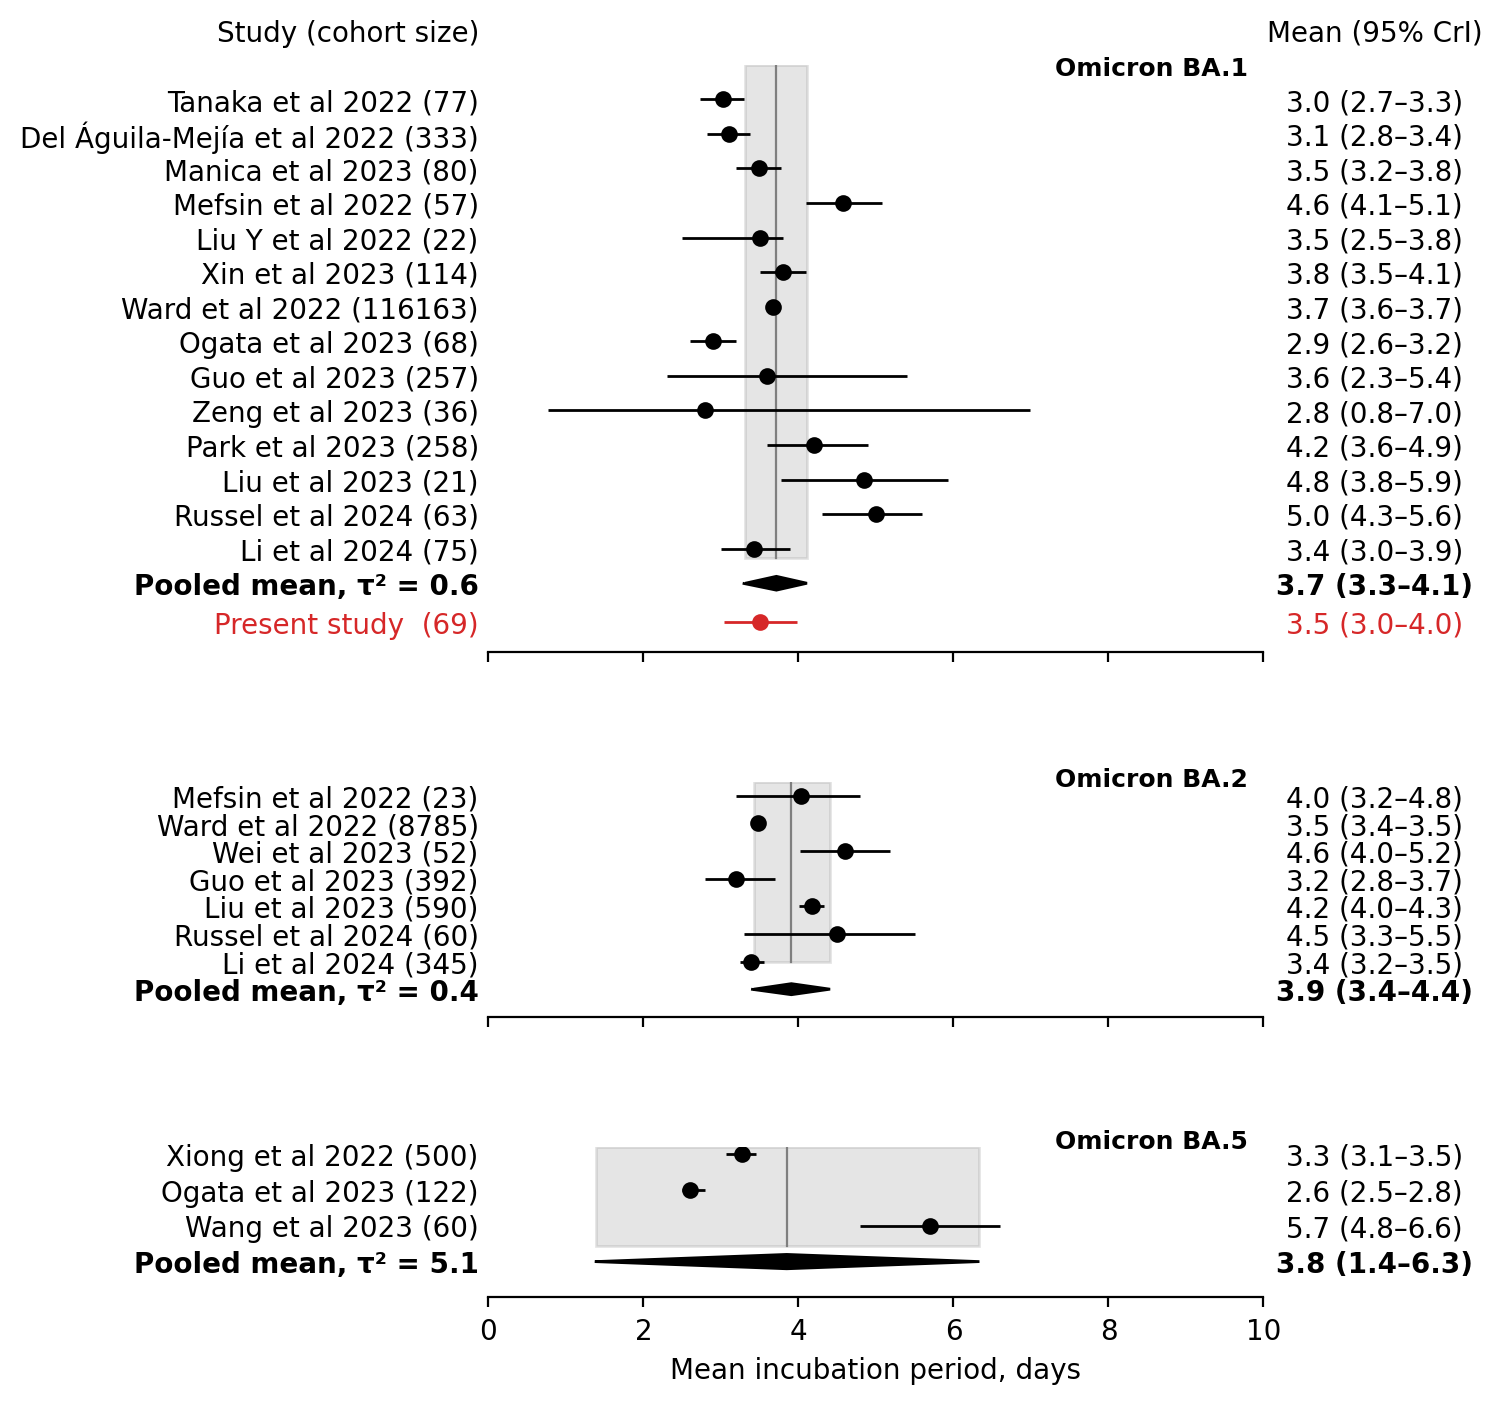

In [89]:
fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [3.5, 1.4, .9], 'hspace': .4})

xmx = 10
cpsz = 0
ymn_ = [.16, .235, .34]
clr_curr_ = 'C3'
clr_ = 'C7'

fig.set_size_inches(5, 8); 

for idx, Omicron_variant_ in enumerate(['BA.1', 'BA.2', 'BA.5']):
    ax = axs[idx]
    df_ = df_inc_review_analyzed.loc[lambda d: (d.Variant==f'Omicron {Omicron_variant_}') & (d.score >= 4)].copy()[::-1]

    df_['Source'] = df_['Study']
    df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['Cases'])]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

    ax.errorbar(x=list(df_['Mean']), 
                y = df_['Source_y'], 
                xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], 
                color='black', capsize=cpsz,
                linestyle='None', linewidth=1, markersize=0)
    ax.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
            linestyle='None', linewidth=1, marker="o", ms=5)

    # Pooled mean
    df_meta_incper_summary_ = df_meta_incper_summary.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()
    mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    
    y_ = 0.0
    h_ = 0.2/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax.add_patch(p)

    ax.axvline(x = mean_meta, ymin = ymn_[idx], linestyle='solid', lw = .8, color=clr_, zorder=-20)
    ax.axvspan(xmin = lower_meta, xmax = upper_meta, ymin = ymn_[idx], zorder = -21, color=clr_, alpha = .2)

    ## current study
    y__ = -0.08
    if (idx == 0):
        df__ = df_current_study.copy()
        df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['Cases'])]
    
        ax.errorbar(x = list(df__['mu']), y = y__, 
                    xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_curr_, capsize=cpsz,
                    linestyle='None', linewidth=1, markersize=0)
        ax.plot(list(df__['mu']), y__, color=clr_curr_, linestyle='None', linewidth=1, marker="o", ms=5)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left = 0, right=xmx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if (idx == 0):
        ax.set_ylim(-2./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )
    else:
        ax.set_ylim(-1./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}']])

    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(ax.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
    if (idx == 0):
        df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
    else:
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})']], ha='center', fontsize=10)
        
    ax2.yaxis.set_tick_params(pad=40)

    [[label.set_fontweight('bold')] if 'Pool' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    [label.set_color(clr_curr_) if 'Present' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_color(clr_curr_) if 'Present' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    if (idx == 0):
        ax.text(-3.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
        ax.text(xmx + .04, 1.12, 'Mean (95% CrI)', horizontalalignment='left', fontsize=10)

    ax.text(xmx * .98, 1.05, f'Omicron {Omicron_variant_}', 
            horizontalalignment='right', fontsize=9, fontweight='bold', color='k')
    
axs[-1].set_xlabel("Mean incubation period, days")
        
plt.show()

#### With pooling across Omicron variants

In [90]:
df_variants_idxs = pd.DataFrame({'Variant': df_inc_review_analyzed.Variant.drop_duplicates().values}).reset_index().rename(columns = {'index': 'Variant_idx'})
df_variants_idxs.Variant_idx += 1
df_variants_idxs

Variant_idx       Variant
0            1  Omicron BA.1
1            2  Omicron BA.2
2            3  Omicron BA.5

In [91]:
basename = f'incper_meta_with_pooling_summary_high_score'
standirname = os.path.join(mainstandirname, basename)
    
!rm {standirname}/*
os.makedirs(standirname, exist_ok=True)

stan_code_file = os.path.join(standirname, f'{basename}.stan')
!cat stan_src/meta_with_pooling.stan > {stan_code_file}

df_ = df_inc_review_analyzed.loc[lambda d: d.score >= 4].copy().merge(df_variants_idxs, how='left')

stan_data = dict({
    'J': df_.shape[0],
    'mu_known': df_['Mean'].values,
    'stderr_known': df_['Mean_stderr'].values,
    'V': len(df_.Variant.drop_duplicates().values),
    'variant': df_.Variant_idx.values
})
stan_data_file = os.path.join(standirname, 'Data.json')
cmdstan.write_stan_json(stan_data_file, stan_data)

model = cmdstan.CmdStanModel(stan_file=stan_code_file)
fit_meta = model.sample(data = stan_data_file, seed = 1, iter_warmup = 4 * num_warmup, iter_sampling = num_iterations,
                   show_console = False, show_progress = True, chains = num_chains, max_treedepth = 14, adapt_delta = 0.9999) 
fit_meta.save_csvfiles(dir = standirname)

df_meta_with_pooling = get_stats(fit_meta, ['mu', 'mu_overall', 'tau_squared', 'tau_squared_overall'])
df_meta_with_pooling

zsh:1: no matches found: ../../../Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary_high_score/*


15:19:56 - cmdstanpy - INFO - compiling stan file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary_high_score/incper_meta_with_pooling_summary_high_score.stan to exe file /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary_high_score/incper_meta_with_pooling_summary_high_score
15:20:03 - cmdstanpy - INFO - compiled model executable: /Users/andrei/Library/CloudStorage/Dropbox/Taiwan_Backup/Taiwan-Omicron_First100_2023/incper_meta_with_pooling_summary_high_score/incper_meta_with_pooling_summary_high_score
15:20:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:20:13 - cmdstanpy - INFO - CmdStan done processing.
15:20:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (0.1%)
	Chain 3 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


var time     mean   hdi2.5    hdi25    hdi75  hdi97.5  \
0                   mu    1  3.76145  3.42313  3.65152  3.87396  4.10400   
1                   mu    2  3.84896  3.47413  3.73711  3.97548  4.23032   
2                   mu    3  3.80984  3.08039  3.63420  3.97489  4.55697   
3           mu_overall   NA  3.80644  3.21340  3.66548  3.94846  4.36806   
4          tau_squared    1  0.54291  0.19714  0.30273  0.53657  1.01971   
5          tau_squared    2  0.40439  0.08292  0.15554  0.35577  0.93322   
6          tau_squared    3  3.04089  0.29177  0.59193  1.93869  8.54897   
7  tau_squared_overall   NA  0.18653  0.00000  0.00000  0.03704  0.71132   

      q2.5      q25   median      q75      q95     q97.5     ess_bulk  \
0  3.41154  3.65133  3.76370  3.87380  4.03710   4.09410  58622.83427   
1  3.47540  3.72811  3.84748  3.96687  4.15877   4.23221  52827.26084   
2  3.07669  3.63724  3.80841  3.97854  4.36293   4.55516  37694.06327   
3  3.23220  3.66351  3.80600  3.94672  4.23219   4.38994  17195.46546   
4  0.24559  0.37703  0.48631  0.64276  1.00126   1.17326  37513.73054   
5  0.12633  0.22495  0.32222  0.47971  0.92643   1.18583  35082.99172   
6  0.53530  1.11442  1.80101  3.14758  8.49160  12.68230  34582.16653   
7  0.00006  0.00740  0.03704  0.13165  0.71127   1.24472  16736.68389   

      ess_tail    r_hat  
0  42679.50738  1.00004  
1  40457.05736  1.00007  
2  26646.98632  1.00007  
3  13244.58053  1.00027  
4  27732.62771  1.00013  
5  26377.94166  1.00014  
6  23189.84266  1.00006  
7  15087.70380  1.00021

In [92]:
df_meta_with_pooling.rename(columns={'time': 'Variant_idx'}).merge(df_variants_idxs, how='left')

var Variant_idx     mean   hdi2.5    hdi25    hdi75  \
0                   mu           1  3.76145  3.42313  3.65152  3.87396   
1                   mu           2  3.84896  3.47413  3.73711  3.97548   
2                   mu           3  3.80984  3.08039  3.63420  3.97489   
3           mu_overall          NA  3.80644  3.21340  3.66548  3.94846   
4          tau_squared           1  0.54291  0.19714  0.30273  0.53657   
5          tau_squared           2  0.40439  0.08292  0.15554  0.35577   
6          tau_squared           3  3.04089  0.29177  0.59193  1.93869   
7  tau_squared_overall          NA  0.18653  0.00000  0.00000  0.03704   

   hdi97.5     q2.5      q25   median      q75      q95     q97.5  \
0  4.10400  3.41154  3.65133  3.76370  3.87380  4.03710   4.09410   
1  4.23032  3.47540  3.72811  3.84748  3.96687  4.15877   4.23221   
2  4.55697  3.07669  3.63724  3.80841  3.97854  4.36293   4.55516   
3  4.36806  3.23220  3.66351  3.80600  3.94672  4.23219   4.38994   
4  1.01971  0.24559  0.37703  0.48631  0.64276  1.00126   1.17326   
5  0.93322  0.12633  0.22495  0.32222  0.47971  0.92643   1.18583   
6  8.54897  0.53530  1.11442  1.80101  3.14758  8.49160  12.68230   
7  0.71132  0.00006  0.00740  0.03704  0.13165  0.71127   1.24472   

      ess_bulk     ess_tail    r_hat       Variant  
0  58622.83427  42679.50738  1.00004  Omicron BA.1  
1  52827.26084  40457.05736  1.00007  Omicron BA.2  
2  37694.06327  26646.98632  1.00007  Omicron BA.5  
3  17195.46546  13244.58053  1.00027           NaN  
4  37513.73054  27732.62771  1.00013  Omicron BA.1  
5  35082.99172  26377.94166  1.00014  Omicron BA.2  
6  34582.16653  23189.84266  1.00006  Omicron BA.5  
7  16736.68389  15087.70380  1.00021           NaN

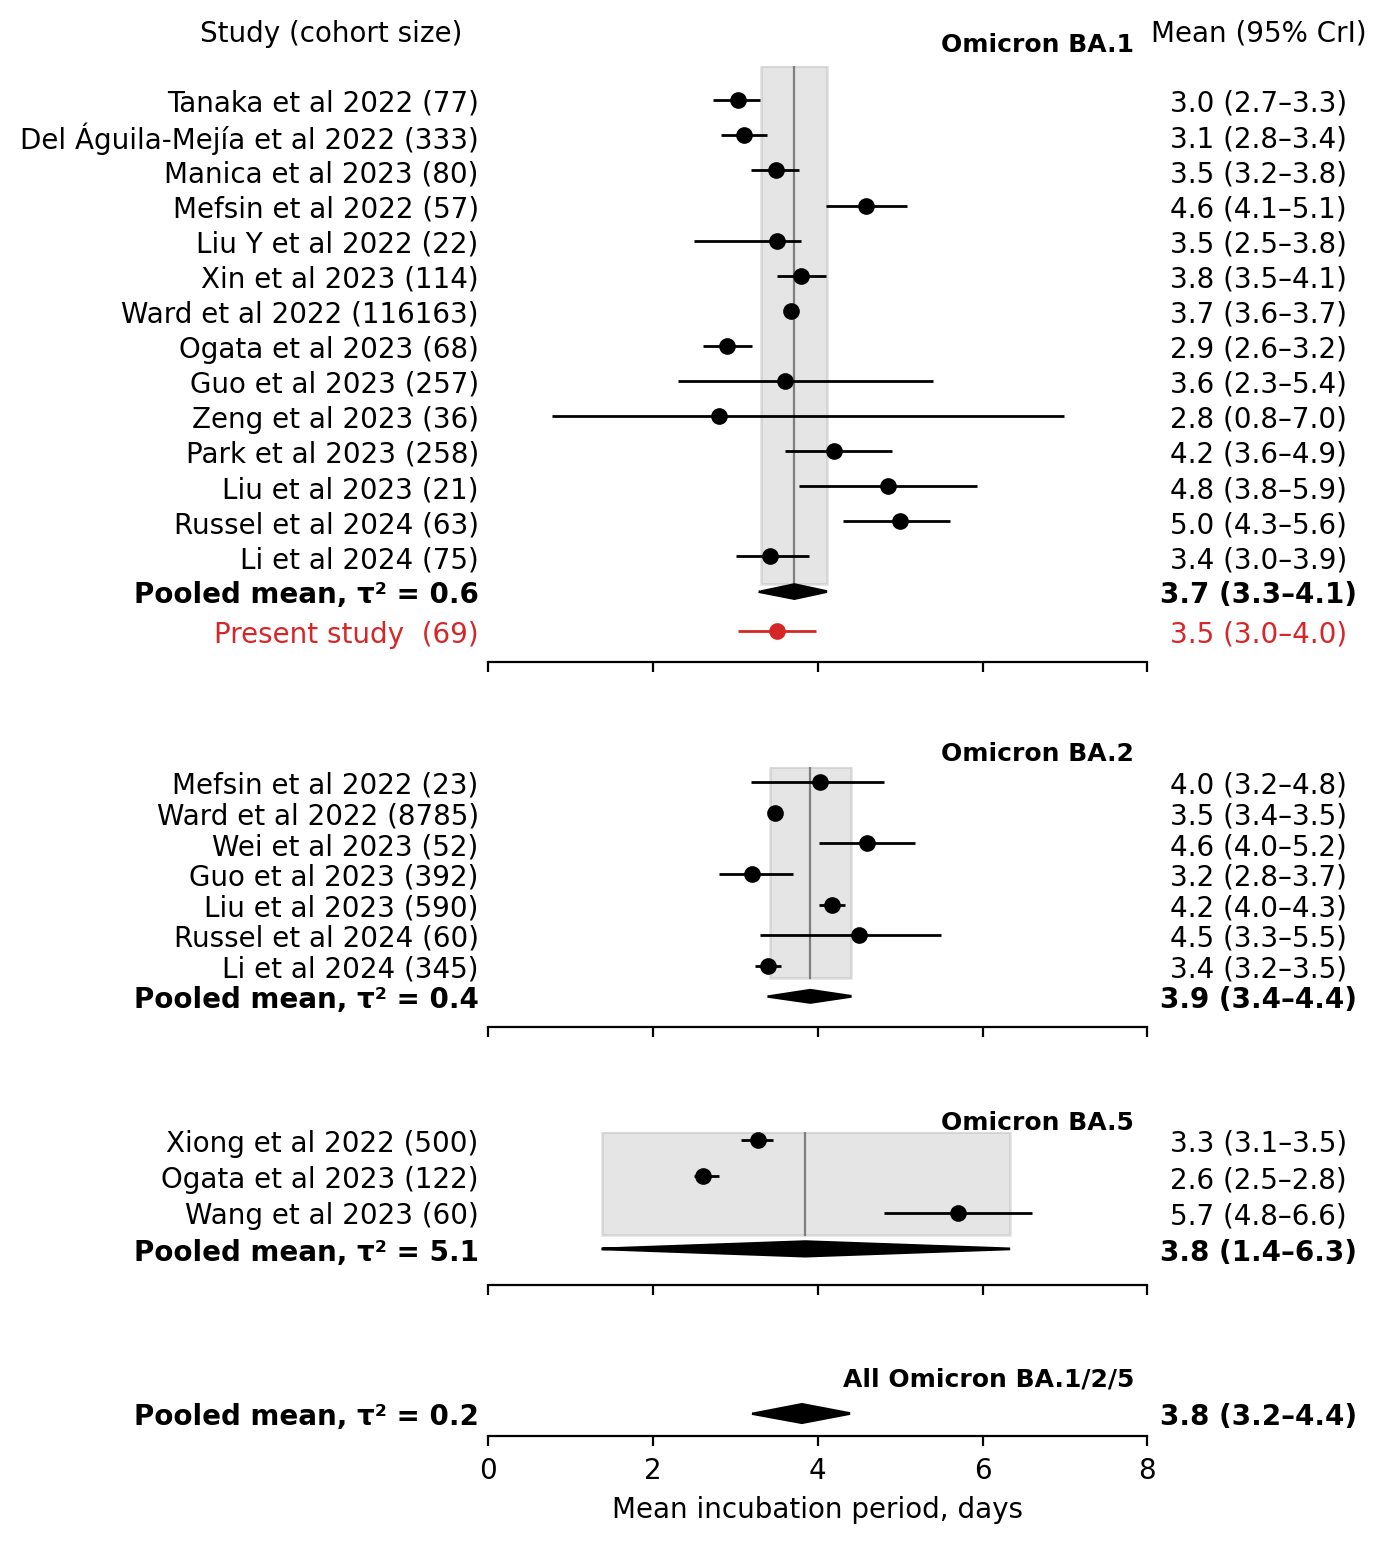

In [93]:
fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3.9, 1.7, 1, .3], 'hspace': .4})

xmx = 8
cpsz = 0
ymn_ = [.13, .19, .33]
clr_curr_ = 'C3'
clr_ = 'C7'

fig.set_size_inches(4.25, 8.9); 

for idx, Omicron_variant_ in enumerate(['BA.1', 'BA.2', 'BA.5']):
    ax = axs[idx]
    df_ = df_inc_review_analyzed.loc[lambda d: (d.Variant==f'Omicron {Omicron_variant_}') & (d.score >= 4)].copy()[::-1]

    df_['Source'] = df_['Study']
    df_['Source'] = [x + ' (' + str(z) + ')' for x,z in zip(df_['Study'], df_['Cases'])]
    df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

    ax.errorbar(x=list(df_['Mean']), 
                y = df_['Source_y'], 
                xerr=[list(df_['Mean'] - df_['Mean_lower']), list(df_['Mean_upper'] - df_['Mean'])], 
                color='black', capsize=cpsz,
                linestyle='None', linewidth=1, markersize=0)
    ax.plot(list(df_['Mean']), df_['Source_y'], color='black', mfc='k', 
            linestyle='None', linewidth=1, marker="o", ms=5)

    # Pooled mean
    # df_meta_incper_summary_ = df_meta_with_pooling.rename(columns={'time': 'Variant_idx'}).merge(df_variants_idxs, how='left').loc[lambda d: d['Variant'] == f'Omicron {Omicron_variant_}']
    df_meta_incper_summary_ = df_meta_incper_summary.loc[lambda d: d.Variant==f'Omicron {Omicron_variant_}'].copy()
    mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'mean'].values[0]
    lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
    upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
    τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
    
    y_ = 0.0
    h_ = 0.2/df_.shape[0]
    from matplotlib.patches import Polygon
    pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
    p = Polygon(pts, closed=False, color='k')
    ax.add_patch(p)

    ax.axvline(x = mean_meta, ymin = ymn_[idx], linestyle='solid', lw = .8, color=clr_, zorder=-20)
    ax.axvspan(xmin = lower_meta, xmax = upper_meta, ymin = ymn_[idx], zorder = -21, color=clr_, alpha = .2)

    ## current study
    y__ = -0.08
    if (idx == 0):
        df__ = df_current_study.copy()
        df__['Source'] = [x + '  (' + str(z) + ')' for x,z in zip(df__['Source'], df__['Cases'])]
    
        ax.errorbar(x = list(df__['mu']), y = y__, 
                    xerr=[list(df__['mu'] - df__['mu_lower']), list(df__['mu_upper'] - df__['mu'])], color=clr_curr_, capsize=cpsz,
                    linestyle='None', linewidth=1, markersize=0)
        ax.plot(list(df__['mu']), y__, color=clr_curr_, linestyle='None', linewidth=1, marker="o", ms=5)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left = 0, right=xmx)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if (idx == 0):
        ax.set_ylim(-2./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}'], df__['Source']] )
    else:
        ax.set_ylim(-1./df_.shape[0], 1.07)
        ax.set_yticks(np.r_[df_['Source_y'], y_])
        ax.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.1f}']])

    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(ax.get_yticks())
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(length=0)
    df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Mean_lower'], df_['Mean_upper'])]
    if (idx == 0):
        df_current_study['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_current_study['mu'], df_current_study['mu_lower'], df_current_study['mu_upper'])]
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], df_current_study['label']], ha='center', fontsize=10)
    else:
        ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})']], ha='center', fontsize=10)
        
    ax2.yaxis.set_tick_params(pad=40)

    [[label.set_fontweight('bold')] if 'Pool' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    [label.set_color(clr_curr_) if 'Present' in label.get_text() else None for label in ax.get_yticklabels()]
    [label2.set_color(clr_curr_) if 'Present' in label.get_text() else None for label, label2 in zip(ax.get_yticklabels(),ax2.get_yticklabels())]

    if (idx == 0):
        ax.text(-3.5, 1.12, 'Study (cohort size)', horizontalalignment='left', fontsize=10)
        ax.text(xmx + .04, 1.12, 'Mean (95% CrI)', horizontalalignment='left', fontsize=10)

    ax.text(xmx * .98, 1.1, f'Omicron {Omicron_variant_}', 
            horizontalalignment='right', fontsize=9, fontweight='bold', color='k')

# Overall meta
ax = axs[-1]
df_meta_incper_summary_ = df_meta_with_pooling.copy()
mean_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'mean'].values[0]
lower_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'q2.5'].values[0]
upper_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='mu_overall', 'q97.5'].values[0]
τsqr_meta = df_meta_incper_summary_.loc[lambda d: d['var']=='tau_squared_overall', 'mean'].values[0]

y_ = 0.5
h_ = 0.2
from matplotlib.patches import Polygon
pts = np.array([[lower_meta, y_], [mean_meta, y_ + h_], [upper_meta, y_], [mean_meta, y_ - h_], [lower_meta * .99, y_]])
p = Polygon(pts, closed=False, color='k')
ax.add_patch(p)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.spines['right'].set_visible(False)
ax.set_xlim(left = 0, right=xmx)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(0, xmx + 2, 2))
ax.set_yticks([y_])
ax.set_yticklabels([f'Pooled mean, τ² = {τsqr_meta:.1f}'])

ax2 = ax.secondary_yaxis("right")
ax2.set_yticks(ax.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(length=0)
ax2.set_yticklabels([f'{mean_meta:.1f} ({lower_meta:.1f}–{upper_meta:.1f})'], ha='center', fontsize=10, fontweight='bold')
ax2.yaxis.set_tick_params(pad=40)

ax.text(xmx * .98, 1.1, f'All Omicron BA.1/2/5', 
        horizontalalignment='right', fontsize=9, fontweight='bold', color='k')
[label.set_fontweight('bold') for label in ax.get_yticklabels()]

axs[-1].set_xlabel("Mean incubation period, days")

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-incper_meta_with_overall_pooled_high_score.pdf", format="pdf", bbox_inches="tight");
        
plt.show()

## Reviews

In [100]:
df_inc_review_Du = pd.read_excel('../../data/review_Du.xlsx').reset_index(drop=True)
df_inc_review_Du['Review'] = 'Du et al. 2022'
df_inc_review_Du

Source  N  Lower  Upper  Mean          Review
0     Pre-Alpha  1    1.8   11.9   6.3  Du et al. 2022
1         Delta  8    3.9    5.6   4.8  Du et al. 2022
2  Omicron BA.1  3    2.3    4.9   3.6  Du et al. 2022

In [101]:
df_inc_review_Wu = pd.read_excel('../../data/review_Wu.xlsx').reset_index(drop=True)
df_inc_review_Wu['Review'] = 'Wu et al. 2022'
df_inc_review_Wu

Source    N  Lower  Upper  Mean          Review
0     Pre-Alpha  NaN   6.31   6.99  6.65  Wu et al. 2022
1         Alpha  NaN   4.94   5.06  5.00  Wu et al. 2022
2         Delta  6.0   3.76   5.05  4.41  Wu et al. 2022
3  Omicron BA.1  5.0   2.88   3.96  3.42  Wu et al. 2022

In [102]:
df_inc_review_Xu = pd.read_excel('../../data/review_Xu.xlsx').reset_index(drop=True)
df_inc_review_Xu['Review'] = 'Xu et al. 2023'
df_inc_review_Xu

Source     N  Mean  Lower  Upper          Review
0     Pre-Alpha   NaN  6.50   5.88   7.12  Xu et al. 2023
1         Alpha   NaN  4.92   4.53   5.30  Xu et al. 2023
2         Delta   NaN  4.63   4.11   5.15  Xu et al. 2023
3  Omicron BA.1  11.0  3.49   3.13   3.86  Xu et al. 2023
4  Omicron BA.2   3.0  4.06   3.18   4.93  Xu et al. 2023
5  Omicron BA.5   3.0  3.81   2.01   5.61  Xu et al. 2023

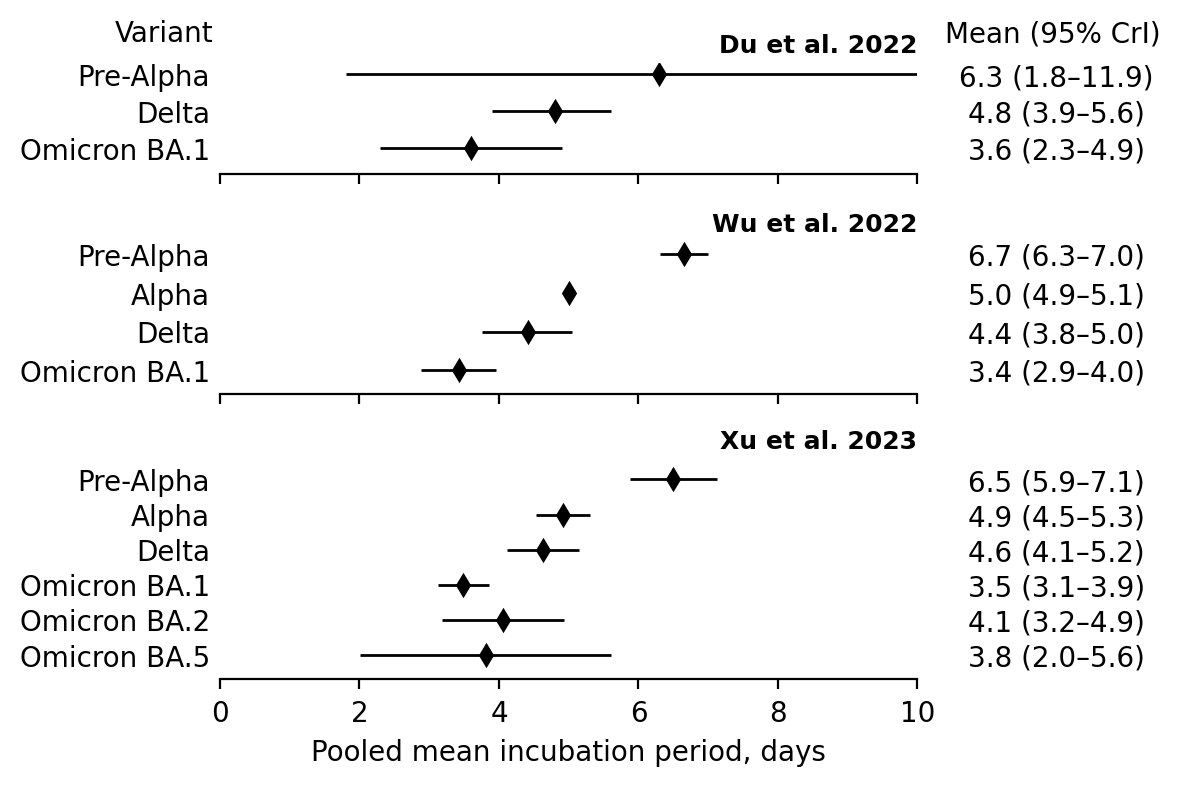

In [103]:
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [1, 1.4, 2], 'hspace': .4})
fig.set_size_inches(4.5, 4); 

clr_Du = 'k'
clr_Wu = 'k'

xmn, xmx = 0, 10

## Du et al. ##
df_ = df_inc_review_Du.copy()[::-1]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], capsize=0,
             linestyle='None', linewidth=1, markersize=0, color=clr_Du)
ax1.plot(list(df_['Mean']), df_['Source_y'], color=clr_Du, linestyle='None', linewidth=1, marker="d", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', length=0)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = xmn, right = xmx)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(.1, 1.1)
ax1.set_yticks(df_['Source_y'])
ax1.set_yticklabels(df_['Source'])

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax2.set_yticklabels(df_['label'], ha='center', fontsize=10)
ax2.yaxis.set_tick_params(pad=50)

ax1.text(-.1, 1.3, 'Variant', horizontalalignment='right', fontsize=10)
ax1.text(xmx + 3.48, 1.3, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)

## Wu et al. ##
df_ = df_inc_review_Wu.copy()[::-1]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax3.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], color=clr_Wu, capsize=0,
             linestyle='None', linewidth=1, markersize=0)
ax3.plot(list(df_['Mean']), df_['Source_y'], color=clr_Wu, linestyle='None', linewidth=1, marker="d", ms=5)

ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(axis='y',length=0)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(left = xmn, right = xmx)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()

ax3.set_xlabel(None)
ax3.set_yticks(df_['Source_y'])
ax3.set_yticklabels(df_['Source'])
ax3.set_ylim(0.1, 1.1)

ax4 = ax3.secondary_yaxis("right")
ax4.set_yticks(ax3.get_yticks())
ax4.spines['right'].set_visible(False)
ax4.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax4.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax4.yaxis.set_tick_params(pad=50)

[label.set_color(clr_Wu) for label in ax3.get_yticklabels()]
[label.set_color(clr_Wu) for label in ax4.get_yticklabels()]

## Xu et al. ##
df_ = df_inc_review_Xu.copy()[::-1]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax5.errorbar(x=list(df_['Mean']), y=df_['Source_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], color=clr_Wu, capsize=0,
             linestyle='None', linewidth=1, markersize=0)
ax5.plot(list(df_['Mean']), df_['Source_y'], color=clr_Wu, linestyle='None', linewidth=1, marker="d", ms=5)

ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.tick_params(axis='y',length=0)
ax5.spines['right'].set_visible(False)
ax5.set_xlim(left = xmn, right = xmx)
ax5.get_xaxis().tick_bottom()
ax5.get_yaxis().tick_left()

ax5.set_xlabel("Pooled mean incubation period, days")
ax5.set_yticks(df_['Source_y'])
ax5.set_yticklabels(df_['Source'])
ax5.set_ylim(0.05, 1.1)

ax6 = ax5.secondary_yaxis("right")
ax6.set_yticks(ax5.get_yticks())
ax6.spines['right'].set_visible(False)
ax6.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax6.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax6.yaxis.set_tick_params(pad=50)

[label.set_color(clr_Wu) for label in ax5.get_yticklabels()]
[label.set_color(clr_Wu) for label in ax6.get_yticklabels()]

ax1.text(xmx, 1.2, 'Du et al. 2022', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Du)
ax3.text(xmx, 1.15, 'Wu et al. 2022', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Wu)
ax5.text(xmx, 1.15, 'Xu et al. 2023', horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Wu)

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-incper_Reviews-2.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [104]:
df_inc_review_analyzed.groupby('Variant')['Study'].count().reset_index().rename(columns = {'Study': 'N'})

Variant   N
0  Omicron BA.1  17
1  Omicron BA.2   8
2  Omicron BA.5   4

In [105]:
# Present study
df_ = df_meta_incper_summary.loc[lambda d: d['var']=='mu'].rename(columns = {'mean': 'Mean', 'q2.5': 'Lower', 'q97.5': 'Upper'}).loc[:, ['Variant', 'Mean', 'Lower', 'Upper']]
df_['Review'] = 'Present analysis, 2024'
df_ = df_.merge(df_inc_review_analyzed.groupby('Variant')['Study'].count().reset_index().rename(columns = {'Study': 'N'}), how='left')

df_reviews = pd.concat([df_inc_review_Du.copy(), df_inc_review_Wu.copy(), df_inc_review_Xu.copy()], ignore_index = True).rename(columns = {'Source': 'Variant'})
df_reviews = pd.concat([df_reviews, df_], ignore_index = True)
df_reviews

Variant     N    Lower     Upper     Mean                  Review
0      Pre-Alpha   1.0  1.80000  11.90000  6.30000          Du et al. 2022
1          Delta   8.0  3.90000   5.60000  4.80000          Du et al. 2022
2   Omicron BA.1   3.0  2.30000   4.90000  3.60000          Du et al. 2022
3      Pre-Alpha   NaN  6.31000   6.99000  6.65000          Wu et al. 2022
4          Alpha   NaN  4.94000   5.06000  5.00000          Wu et al. 2022
5          Delta   6.0  3.76000   5.05000  4.41000          Wu et al. 2022
6   Omicron BA.1   5.0  2.88000   3.96000  3.42000          Wu et al. 2022
7      Pre-Alpha   NaN  5.88000   7.12000  6.50000          Xu et al. 2023
8          Alpha   NaN  4.53000   5.30000  4.92000          Xu et al. 2023
9          Delta   NaN  4.11000   5.15000  4.63000          Xu et al. 2023
10  Omicron BA.1  11.0  3.13000   3.86000  3.49000          Xu et al. 2023
11  Omicron BA.2   3.0  3.18000   4.93000  4.06000          Xu et al. 2023
12  Omicron BA.5   3.0  2.01000   5.61000  3.81000          Xu et al. 2023
13  Omicron BA.1  17.0  3.35562   4.01337  3.68522  Present analysis, 2024
14  Omicron BA.2   8.0  3.30858   4.29292  3.79950  Present analysis, 2024
15  Omicron BA.5   4.0  1.75968   5.40708  3.53792  Present analysis, 2024

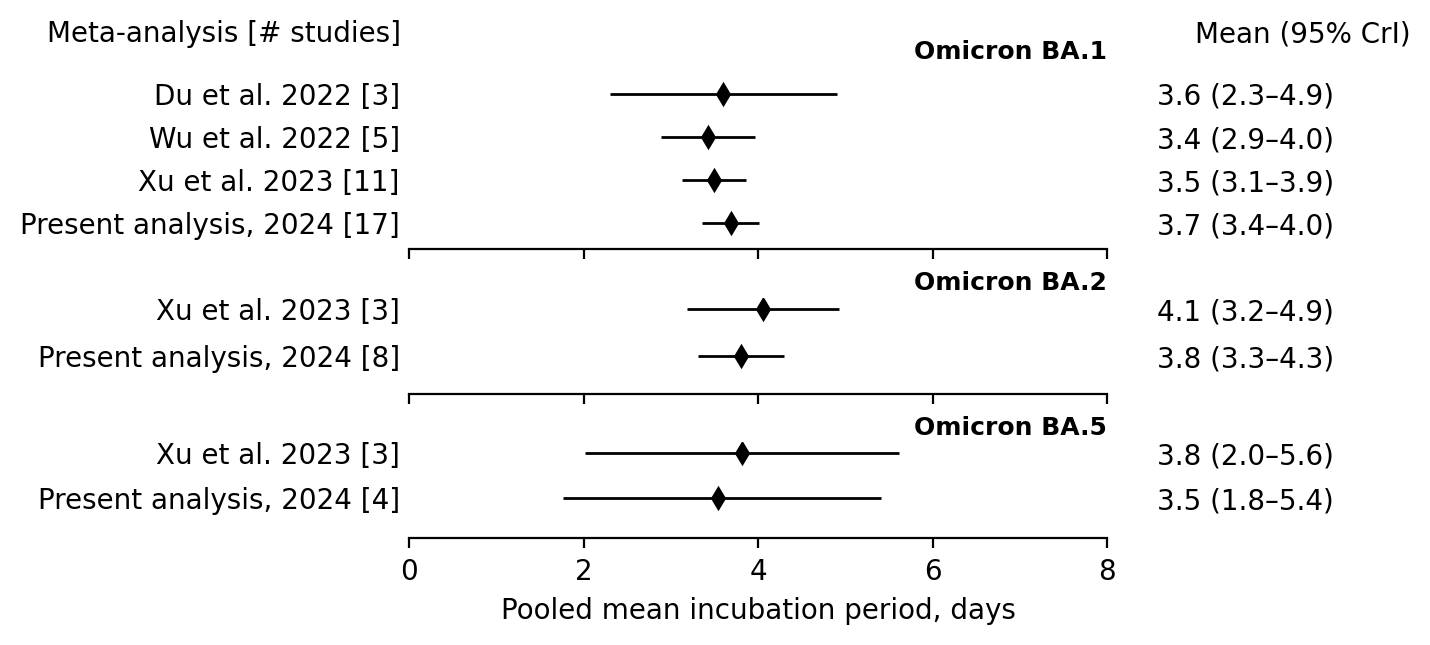

In [106]:
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [1.8, 1, 1], 'hspace': .4})
fig.set_size_inches(4.5, 3); 

clr_Du = 'k'
clr_Wu = 'k'

xmn, xmx = 0, 8

## Omicron BA.1 ##
variant_ = 'Omicron BA.1'
df_ = df_reviews.loc[lambda d: d['Variant']==variant_].copy()[::-1]
df_['Review'] = [f'{Review} [{int(N)}]' for Review, N in zip(df_['Review'], df_['N'])]
df_['Review_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax1.errorbar(x=list(df_['Mean']), y=df_['Review_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], capsize=0,
             linestyle='None', linewidth=1, markersize=0, color='k')
ax1.plot(list(df_['Mean']), df_['Review_y'], color=clr_Du, linestyle='None', linewidth=1, marker="d", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', length=0)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = xmn, right = xmx)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_ylim(.1, 1.1)
ax1.set_yticks(df_['Review_y'])
ax1.set_yticklabels(df_['Review'])

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax2.set_yticklabels(df_['label'], ha='center', fontsize=10)
ax2.yaxis.set_tick_params(pad=50)

ax1.text(-.1, 1.3, 'Meta-analysis [# studies]', horizontalalignment='right', fontsize=10)
ax1.text(xmx + 3.48, 1.3, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)

ax1.text(xmx, 1.2, variant_, horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Du)

## Omicron BA.2 ##
variant_ = 'Omicron BA.2'
df_ = df_reviews.loc[lambda d: d['Variant']==variant_].copy()[::-1]
df_['Review'] = [f'{Review} [{int(N)}]' for Review, N in zip(df_['Review'], df_['N'])]
df_['Review_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax3.errorbar(x=list(df_['Mean']), y=df_['Review_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], color=clr_Wu, capsize=0,
             linestyle='None', linewidth=1, markersize=0)
ax3.plot(list(df_['Mean']), df_['Review_y'], color=clr_Wu, linestyle='None', linewidth=1, marker="d", ms=5)

ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.tick_params(axis='y',length=0)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(left = xmn, right = xmx)
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()

ax3.set_xlabel(None)
ax3.set_yticks(df_['Review_y'])
ax3.set_yticklabels(df_['Review'])
ax3.set_ylim(0.1, 1.12)

ax4 = ax3.secondary_yaxis("right")
ax4.set_yticks(ax3.get_yticks())
ax4.spines['right'].set_visible(False)
ax4.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax4.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax4.yaxis.set_tick_params(pad=50)

ax3.text(xmx, 1.2, variant_, horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Du)

## Omicron BA.5 ##
variant_ = 'Omicron BA.5'
df_ = df_reviews.loc[lambda d: d['Variant']==variant_].copy()[::-1]
df_['Review'] = [f'{Review} [{int(N)}]' for Review, N in zip(df_['Review'], df_['N'])]
df_['Review_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

ax5.errorbar(x=list(df_['Mean']), y=df_['Review_y'], xerr=[list(df_['Mean'] - df_['Lower']), list(df_['Upper'] - df_['Mean'])], color=clr_Wu, capsize=0,
             linestyle='None', linewidth=1, markersize=0)
ax5.plot(list(df_['Mean']), df_['Review_y'], color=clr_Wu, linestyle='None', linewidth=1, marker="d", ms=5)

ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.tick_params(axis='y',length=0)
ax5.spines['right'].set_visible(False)
ax5.set_xlim(left = xmn, right = xmx)
ax5.get_xaxis().tick_bottom()
ax5.get_yaxis().tick_left()

ax5.set_xlabel("Pooled mean incubation period, days")
ax5.set_xticks(np.arange(0, xmx + 2, 2))
ax5.set_yticks(df_['Review_y'])
ax5.set_yticklabels(df_['Review'])
ax5.set_ylim(0.05, 1.12)

ax6 = ax5.secondary_yaxis("right")
ax6.set_yticks(ax5.get_yticks())
ax6.spines['right'].set_visible(False)
ax6.tick_params(axis='y',length=0)
df_['label'] = [f"{mu:.1f} ({mu_lower:.1f}–{mu_upper:.1f})" for mu, mu_lower, mu_upper in zip(df_['Mean'], df_['Lower'], df_['Upper'])]
ax6.set_yticklabels(df_['label'].values, ha='center', fontsize=10)
ax6.yaxis.set_tick_params(pad=50)

ax5.text(xmx, 1.2, variant_, horizontalalignment='right', fontsize=9, fontweight='bold', color=clr_Du)

if save_figures:
    plt.savefig("../../figures_ms/draft/fig-incper_Reviews.pdf", format="pdf", bbox_inches="tight")

plt.show()